In [1]:
import os
import sys
import pickle
from tqdm.notebook import tqdm as tqdm
import random

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

sys.path.append("../")

from batch_generators import ContrastiveDataGenerator, BinaryDataGenerator
from models import ContrastiveRankingModel, metabric_main_network
from tools import test_quality
from clr import cyclic_learning_rate

In [2]:
s = 2

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

##### Load METABRIC data

In [3]:
with open('../data/metabric_cv.pkl', 'rb') as f:
    df_all = pickle.load(f)

In [4]:
df_all.keys()

dict_keys(['val', 'cv'])

In [5]:
df_all['cv'].keys()

dict_keys([0, 1, 2, 3, 4])

In [6]:
folds = list(df_all['cv'].keys())

In [7]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive = 30

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr': 0.0001
}


In [8]:
batch_size = [1024]
alpha_reg = [1e-6]

contrastive_weight = [0.1]
margin_weight = [0.01]

param_grid = {
    'batch_size': batch_size, 
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': contrastive_weight
}
grid = ParameterGrid(param_grid)

In [11]:
def test_hp(train_data, test_data, model_params):
    
    model = ContrastiveRankingModel(input_shape=model_params['inp_shape'], seed=model_params['seed'], alpha_reg=model_params['alpha_reg'], 
                                    main_network=metabric_main_network, 
                                    contrastive_weight=model_params['contrastive_weight'], margin_weight=model_params['margin_weight'])
    ## contrastive data generator
    # validation data
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], 
                                  n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val_contrastive, x_batch_right_val_contrastive], y_batch_val_contrastive, sample_weight_val_contrastive, target_val_contrastive = next(
        dg.get_batch())
    val_size_contrastive = x_batch_left_val_contrastive.shape[0]
    # training data
    dg_contrastive = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])    
    n_batches_contrastive = min(dg_contrastive.ij_pos_sorted.shape[1], dg_contrastive.ij_neg_sorted.shape[1]) // model_params['batch_size']
    n_epochs_contrastive = model_params['n_epochs_contrastive']
    
    ## binary data generator    
    # validation data
    dg = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg_binary = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val_binary, x_batch_right_val_binary], y_batch_val_binary, sample_weight_val_binary, target_val_binary = next(dg.get_batch())
    val_size_binary = x_batch_left_val_binary.shape[0]
    # training data
    dg_binary = BinaryDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])
    n_batches_binary = min(dg_binary.ij_pos_sorted.shape[1], dg_binary.ij_neg_sorted.shape[1]) // model_params['batch_size']
    n_epochs_binary = model_params['n_epochs_binary']
    
    # optimizators
    # cycling learning rate
    all_lr = []
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = cyclic_learning_rate(global_step=global_step, learning_rate=model_params['max_lr'] / 5, max_lr=model_params['max_lr'], 
                                         step_size=model_params['step_size'], mode='triangular2')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op_weibull = optimizer.minimize(model.main_loss, global_step=global_step)
    
    
    # standard GradientDescentOptimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_params['learning_rate_contr'])
    train_op_contrastive = optimizer.minimize(model.loss)
    
    all_pred = []
    train_loss = []
    val_loss = []
    train_contr_loss = []
    val_contr_loss = []
    # Launch the graph
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            init = tf.initialize_all_variables()
            sess.run(init)
            
            ## train standard weibull loss on binary batch generator
            for i in tqdm(range(n_epochs_binary)):
                # initialize generator
                gen = dg_binary.get_batch()
                # for each batch
                for j in range(n_batches_binary):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }
                    
                    # train model
                    _, l = sess.run([train_op_weibull, model.main_loss], feed_dict=feed_dict)
                    
                 # change learning rate
                assign_op = global_step.assign(i)
                sess.run(assign_op)               
                new_lr = sess.run(optimizer._learning_rate_tensor)
                all_lr.append(new_lr)
                
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                # save test loss
                l = sess.run([model.main_loss], feed_dict={
                    model.x_a: x_batch_left_val_binary, 
                    model.x_b: x_batch_right_val_binary, 
                    model.t_a: y_batch_val_binary[:, 0].reshape((val_size_binary, 1)),
                    model.t_b: y_batch_val_binary[:, 1].reshape((val_size_binary, 1)),
                    model.y_a: y_batch_val_binary[:, 2].reshape((val_size_binary, 1)),
                    model.y_b: y_batch_val_binary[:, 3].reshape((val_size_binary, 1)),
                    model.target: target_val_binary.reshape((val_size_binary, 1)),
                    model.sample_weight: sample_weight_val_binary
                }) 
                val_loss.append(l)
                
            print(tf.trainable_variables)   
                
            ## train contrastive loss on contrastive batch generator
            for i in tqdm(range(n_epochs_contrastive)):
                # initialize generator
                gen = dg_contrastive.get_batch()
                # for each batch
                for j in range(n_batches_contrastive):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }
                    
                    # train model
                    _, l, l_c = sess.run([train_op_contrastive, model.main_loss, model.loss], feed_dict=feed_dict)
              
                 # change learning rate
                assign_op = global_step.assign(i)
                sess.run(assign_op)               
                new_lr = sess.run(optimizer._learning_rate_tensor)
                all_lr.append(new_lr)
                
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                train_contr_loss.append(l_c)
                # save test loss
                l, l_c = sess.run([model.main_loss, model.loss], feed_dict={
                    model.x_a: x_batch_left_val_contrastive, 
                    model.x_b: x_batch_right_val_contrastive, 
                    model.t_a: y_batch_val_contrastive[:, 0].reshape((val_size_contrastive, 1)),
                    model.t_b: y_batch_val_contrastive[:, 1].reshape((val_size_contrastive, 1)),
                    model.y_a: y_batch_val_contrastive[:, 2].reshape((val_size_contrastive, 1)),
                    model.y_b: y_batch_val_contrastive[:, 3].reshape((val_size_contrastive, 1)),
                    model.target: target_val_contrastive.reshape((val_size_contrastive, 1)),
                    model.sample_weight: sample_weight_val_contrastive
                }) 
                val_loss.append(l)     
                val_contr_loss.append(l)
                
            print(tf.trainable_variables)

    return pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr


In [12]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
params = grid[0]
tf.reset_default_graph()
params.update(static_params)
pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)
q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103)
q['batch_size'] = params['batch_size']
q['alpha_reg'] = params['alpha_reg']
q['fold'] = fold
q['train_loss'] = [train_loss]
q['val_loss'] = [val_loss]
q

harell_c_index  dt_c_index  int_brier_score  int_nbill  batch_size  \
0        0.467808    0.503859         0.210006   0.609374        1024   

   alpha_reg  fold                                         train_loss  \
0   0.000001     0  [5.284485, 3.6474648, 3.2131922, 2.9851174, 2....   

                                            val_loss  
0  [[4.9744415], [3.6291811], [3.196431], [2.9230...

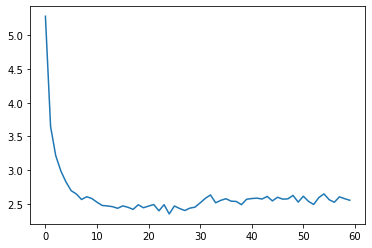

In [14]:
plt.plot(train_loss)
# plt.plot(val_loss)

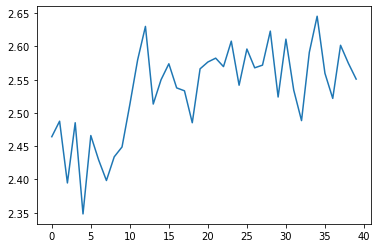

In [16]:
plt.plot(train_loss[20:])

In [17]:
q

harell_c_index  dt_c_index  int_brier_score  int_nbill  batch_size  \
0        0.467808    0.503859         0.210006   0.609374        1024   

   alpha_reg  fold                                         train_loss  \
0   0.000001     0  [5.284485, 3.6474648, 3.2131922, 2.9851174, 2....   

                                            val_loss  
0  [[4.9744415], [3.6291811], [3.196431], [2.9230...

На 10 эпох замораживаем веса 

In [21]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive_freezed = 10
n_epochs_contrastive = 20

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive_freezed': n_epochs_contrastive_freezed,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr': 0.0001,
    'learning_rate_contr_freezed': 0.0001
}


In [22]:
batch_size = [1024]
alpha_reg = [1e-6]

contrastive_weight = [0.1]
margin_weight = [0.01]

param_grid = {
    'batch_size': batch_size, 
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': contrastive_weight
}
grid = ParameterGrid(param_grid)

In [23]:
def test_hp(train_data, test_data, model_params):
    tf.reset_default_graph()
    model = ContrastiveRankingModel(input_shape=model_params['inp_shape'], seed=model_params['seed'], alpha_reg=model_params['alpha_reg'], 
                                    main_network=metabric_main_network, 
                                    contrastive_weight=model_params['contrastive_weight'], margin_weight=model_params['margin_weight'])
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    ## contrastive data generator
    # validation data
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], 
                                  n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val_contrastive, x_batch_right_val_contrastive], y_batch_val_contrastive, sample_weight_val_contrastive, target_val_contrastive = next(
        dg.get_batch())
    val_size_contrastive = x_batch_left_val_contrastive.shape[0]
    # training data
    dg_contrastive = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])    
    n_batches_contrastive = min(dg_contrastive.ij_pos_sorted.shape[1], dg_contrastive.ij_neg_sorted.shape[1]) // model_params['batch_size']
    n_epochs_contrastive = model_params['n_epochs_contrastive']
    n_epochs_contrastive_freezed = model_params['n_epochs_contrastive_freezed']
    
    ## binary data generator    
    # validation data
    dg = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg_binary = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val_binary, x_batch_right_val_binary], y_batch_val_binary, sample_weight_val_binary, target_val_binary = next(dg.get_batch())
    val_size_binary = x_batch_left_val_binary.shape[0]
    # training data
    dg_binary = BinaryDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])
    n_batches_binary = min(dg_binary.ij_pos_sorted.shape[1], dg_binary.ij_neg_sorted.shape[1]) // model_params['batch_size']
    n_epochs_binary = model_params['n_epochs_binary']
    
    # optimizators
    # cycling learning rate
    all_lr = []
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = cyclic_learning_rate(global_step=global_step, learning_rate=model_params['max_lr'] / 5, max_lr=model_params['max_lr'], 
                                         step_size=model_params['step_size'], mode='triangular2')

    
    all_pred = []
    train_loss = []
    val_loss = []
    train_contr_loss = []
    val_contr_loss = []
    # Launch the graph
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            
            optimizer1 = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            train_op_weibull = optimizer1.minimize(model.main_loss, global_step=global_step, var_list=trainable_binary)
            optimizer2 = tf.train.GradientDescentOptimizer(learning_rate=model_params['learning_rate_contr'])
            train_op_contrastive = optimizer2.minimize(model.loss, var_list=trainable_contr_binary)
            optimizer3 = tf.train.GradientDescentOptimizer(learning_rate=model_params['learning_rate_contr_freezed'])
            train_op_contrastive_freezed = optimizer3.minimize(model.loss, var_list=trainable_contr)  
            
            init = tf.initialize_all_variables()
            sess.run(init)
            
            ## train standard weibull loss on binary batch generator
            for i in tqdm(range(n_epochs_binary)):
                # initialize generator
                gen = dg_binary.get_batch()
                # for each batch
                for j in range(n_batches_binary):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }
                    
                    # train model
                    _, l = sess.run([train_op_weibull, model.main_loss], feed_dict=feed_dict)
                    
                 # change learning rate
                assign_op = global_step.assign(i)
                sess.run(assign_op)               
                new_lr = sess.run(optimizer1._learning_rate_tensor)
                all_lr.append(new_lr)
                
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                # save test loss
                l = sess.run([model.main_loss], feed_dict={
                    model.x_a: x_batch_left_val_binary, 
                    model.x_b: x_batch_right_val_binary, 
                    model.t_a: y_batch_val_binary[:, 0].reshape((val_size_binary, 1)),
                    model.t_b: y_batch_val_binary[:, 1].reshape((val_size_binary, 1)),
                    model.y_a: y_batch_val_binary[:, 2].reshape((val_size_binary, 1)),
                    model.y_b: y_batch_val_binary[:, 3].reshape((val_size_binary, 1)),
                    model.target: target_val_binary.reshape((val_size_binary, 1)),
                    model.sample_weight: sample_weight_val_binary
                }) 
                val_loss.append(l)
                

            ## train contrastive loss on contrastive batch generator FREEZED
            for i in tqdm(range(n_epochs_contrastive_freezed)):
                # initialize generator
                gen = dg_contrastive.get_batch()
                # for each batch
                for j in range(n_batches_contrastive):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }
                    
                    # train model
                    _, l, l_c = sess.run([train_op_contrastive_freezed, model.main_loss, model.loss], feed_dict=feed_dict)
              
                 # change learning rate
                assign_op = global_step.assign(i)
                sess.run(assign_op)               
                new_lr = sess.run(optimizer3._learning_rate_tensor)
                all_lr.append(new_lr)
                
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                train_contr_loss.append(l_c)
                # save test loss
                l, l_c = sess.run([model.main_loss, model.loss], feed_dict={
                    model.x_a: x_batch_left_val_contrastive, 
                    model.x_b: x_batch_right_val_contrastive, 
                    model.t_a: y_batch_val_contrastive[:, 0].reshape((val_size_contrastive, 1)),
                    model.t_b: y_batch_val_contrastive[:, 1].reshape((val_size_contrastive, 1)),
                    model.y_a: y_batch_val_contrastive[:, 2].reshape((val_size_contrastive, 1)),
                    model.y_b: y_batch_val_contrastive[:, 3].reshape((val_size_contrastive, 1)),
                    model.target: target_val_contrastive.reshape((val_size_contrastive, 1)),
                    model.sample_weight: sample_weight_val_contrastive
                }) 
                val_loss.append(l)     
                val_contr_loss.append(l_c)
                
                
                
                
            ## train contrastive loss on contrastive batch generator
            for i in tqdm(range(n_epochs_contrastive)):
                # initialize generator
                gen = dg_contrastive.get_batch()
                # for each batch
                for j in range(n_batches_contrastive):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }
                    
                    # train model
                    _, l, l_c = sess.run([train_op_contrastive, model.main_loss, model.loss], feed_dict=feed_dict)
              
                 # change learning rate
                assign_op = global_step.assign(i)
                sess.run(assign_op)               
                new_lr = sess.run(optimizer2._learning_rate_tensor)
                all_lr.append(new_lr)
                
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                train_contr_loss.append(l_c)
                # save test loss
                l, l_c = sess.run([model.main_loss, model.loss], feed_dict={
                    model.x_a: x_batch_left_val_contrastive, 
                    model.x_b: x_batch_right_val_contrastive, 
                    model.t_a: y_batch_val_contrastive[:, 0].reshape((val_size_contrastive, 1)),
                    model.t_b: y_batch_val_contrastive[:, 1].reshape((val_size_contrastive, 1)),
                    model.y_a: y_batch_val_contrastive[:, 2].reshape((val_size_contrastive, 1)),
                    model.y_b: y_batch_val_contrastive[:, 3].reshape((val_size_contrastive, 1)),
                    model.target: target_val_contrastive.reshape((val_size_contrastive, 1)),
                    model.sample_weight: sample_weight_val_contrastive
                }) 
                val_loss.append(l)     
                val_contr_loss.append(l_c)

    return all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr


In [37]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
params = grid[0]
tf.reset_default_graph()
params.update(static_params)
all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)

In [72]:
val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]

all_q = []
for pred in all_pred:
    all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
df_all_q = pd.concat(all_q)

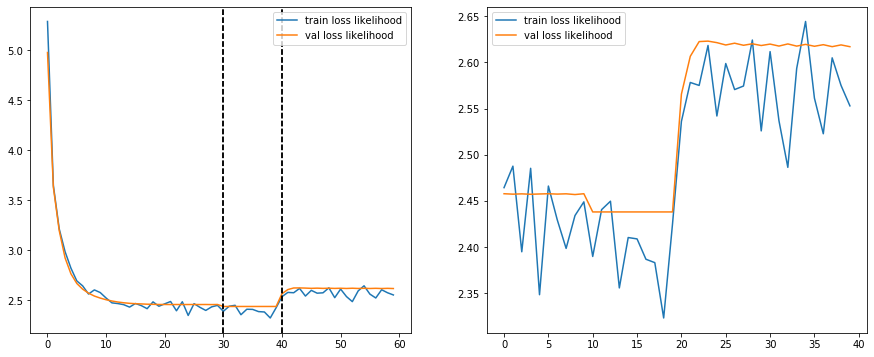

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax[0].plot(train_loss, label='train loss likelihood')
ax[0].plot(val_loss, label='val loss likelihood')
ax[0].legend(loc=1)
ax[0].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
ax[1].plot(train_loss[20:], label='train loss likelihood')
ax[1].plot(val_loss[20:], label='val loss likelihood')
ax[1].legend(loc=2)

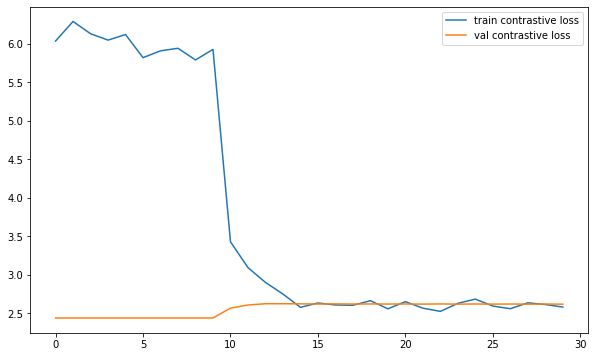

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(train_contr_loss, label='train contrastive loss')
plt.plot(val_contr_loss, label='val contrastive loss')
plt.legend(loc=1);

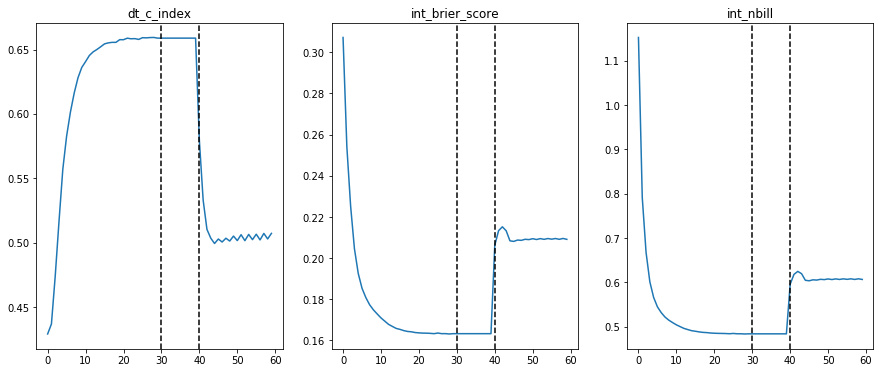

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
ax[0].plot(df_all_q['dt_c_index'].values)
ax[0].set_title('dt_c_index')
ax[0].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
ax[1].plot(df_all_q['int_brier_score'].values)
ax[1].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[1].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
ax[1].set_title('int_brier_score')
ax[2].plot(df_all_q['int_nbill'].values)
ax[2].set_title('int_nbill')
ax[2].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[2].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--');

n_epochs_contrastive_freezed - 10 -> 50

In [14]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive_freezed = 50
n_epochs_contrastive = 20

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive_freezed': n_epochs_contrastive_freezed,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr': 0.0001,
    'learning_rate_contr_freezed': 0.0001
}


In [15]:
batch_size = [1024]
alpha_reg = [1e-6]

contrastive_weight = [0.1]
margin_weight = [0.01]

param_grid = {
    'batch_size': batch_size, 
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': contrastive_weight
}
grid = ParameterGrid(param_grid)

In [16]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
params = grid[0]
tf.reset_default_graph()
params.update(static_params)
all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)

In [17]:
val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]

all_q = []
for pred in all_pred:
    all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
df_all_q = pd.concat(all_q)

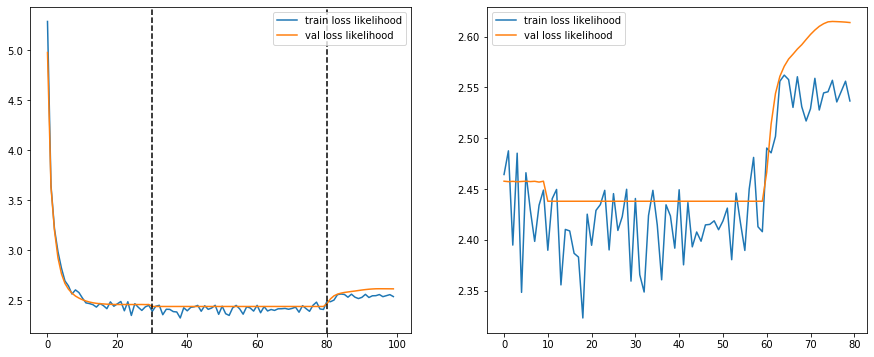

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax[0].plot(train_loss, label='train loss likelihood')
ax[0].plot(val_loss, label='val loss likelihood')
ax[0].legend(loc=1)
ax[0].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
ax[1].plot(train_loss[20:], label='train loss likelihood')
ax[1].plot(val_loss[20:], label='val loss likelihood')
ax[1].legend(loc=2)

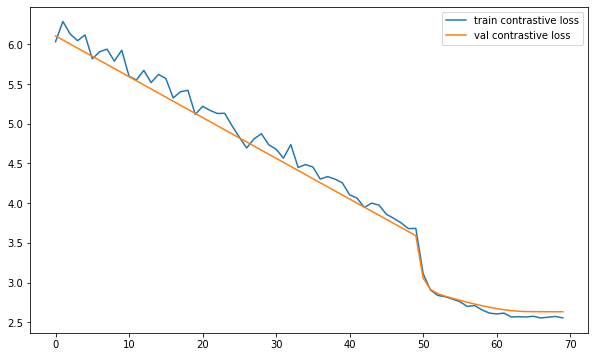

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train_contr_loss, label='train contrastive loss')
plt.plot(val_contr_loss, label='val contrastive loss')
plt.legend(loc=1);

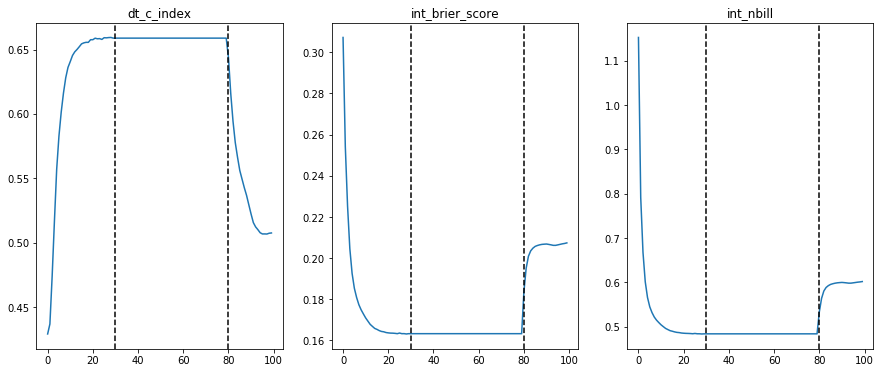

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
ax[0].plot(df_all_q['dt_c_index'].values)
ax[0].set_title('dt_c_index')
ax[0].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
ax[1].plot(df_all_q['int_brier_score'].values)
ax[1].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[1].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
ax[1].set_title('int_brier_score')
ax[2].plot(df_all_q['int_nbill'].values)
ax[2].set_title('int_nbill')
ax[2].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[2].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--');

contrastive phase - smaller learning rate learning_rate_contr 0.0001 -> 0.00005

n_epochs_contrastive_freezed - 50 -> 100

In [24]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive_freezed = 100
n_epochs_contrastive = 20

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive_freezed': n_epochs_contrastive_freezed,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr_freezed': 0.0001,
    'learning_rate_contr': 0.00005
}


In [25]:
batch_size = [1024]
alpha_reg = [1e-6]

contrastive_weight = [0.1]
margin_weight = [0.01]

param_grid = {
    'batch_size': batch_size, 
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': contrastive_weight
}
grid = ParameterGrid(param_grid)

In [26]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
params = grid[0]
tf.reset_default_graph()
params.update(static_params)
all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)

In [27]:
val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]

all_q = []
for pred in all_pred:
    all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
df_all_q = pd.concat(all_q)

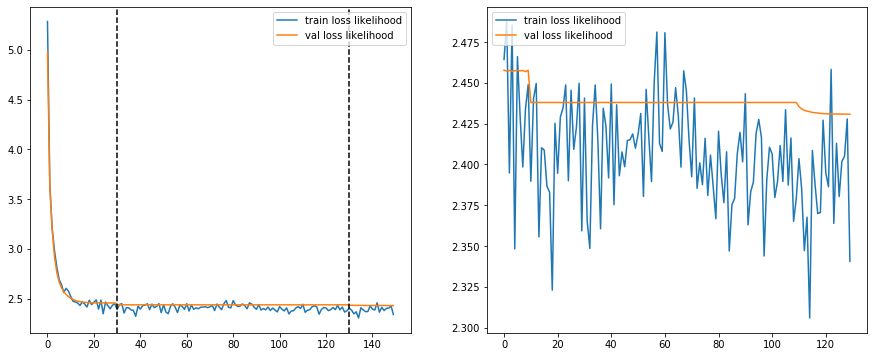

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax[0].plot(train_loss, label='train loss likelihood')
ax[0].plot(val_loss, label='val loss likelihood')
ax[0].legend(loc=1)
ax[0].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
ax[1].plot(train_loss[20:], label='train loss likelihood')
ax[1].plot(val_loss[20:], label='val loss likelihood')
ax[1].legend(loc=2)

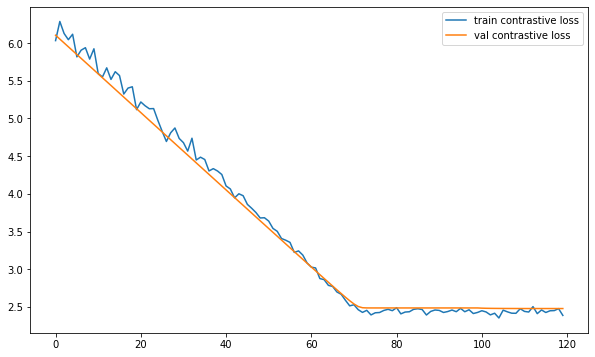

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(train_contr_loss, label='train contrastive loss')
plt.plot(val_contr_loss, label='val contrastive loss')
plt.legend(loc=1);

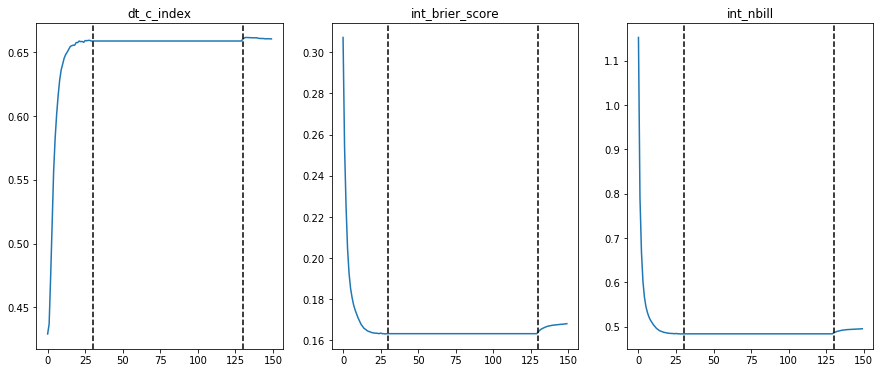

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
ax[0].plot(df_all_q['dt_c_index'].values)
ax[0].set_title('dt_c_index')
ax[0].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
ax[1].plot(df_all_q['int_brier_score'].values)
ax[1].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[1].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
ax[1].set_title('int_brier_score')
ax[2].plot(df_all_q['int_nbill'].values)
ax[2].set_title('int_nbill')
ax[2].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[2].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--');

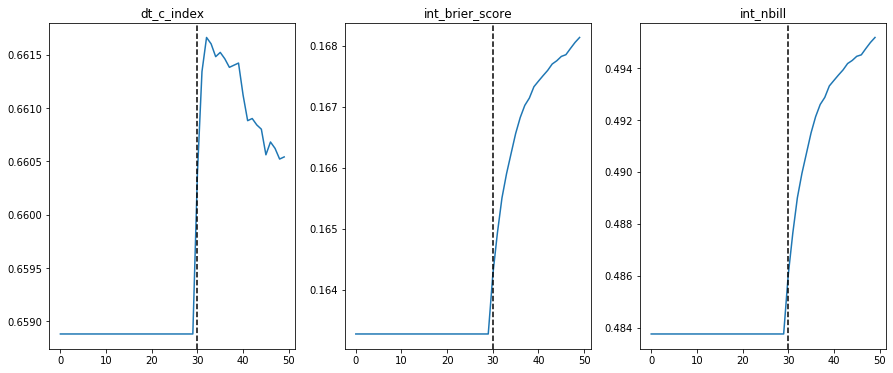

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
ax[0].plot(df_all_q['dt_c_index'].values[100:])
ax[0].set_title('dt_c_index')
ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed']-100, c='black', linestyle='--')
ax[1].plot(df_all_q['int_brier_score'].values[100:])
ax[1].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed']-100, c='black', linestyle='--')
ax[1].set_title('int_brier_score')
ax[2].plot(df_all_q['int_nbill'].values[100:])
ax[2].set_title('int_nbill')
ax[2].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'] - 100, c='black', linestyle='--');

contrastive weight 0.1 -> 0.05

In [32]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive_freezed = 100
n_epochs_contrastive = 20

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive_freezed': n_epochs_contrastive_freezed,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr_freezed': 0.0001,
    'learning_rate_contr': 0.00005
}


In [33]:
batch_size = [1024]
alpha_reg = [1e-6]

contrastive_weight = [0.05]
margin_weight = [0.01]

param_grid = {
    'batch_size': batch_size, 
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': contrastive_weight
}
grid = ParameterGrid(param_grid)

In [34]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
params = grid[0]
tf.reset_default_graph()
params.update(static_params)
all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)

In [35]:
val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]

all_q = []
for pred in all_pred:
    all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
df_all_q = pd.concat(all_q)

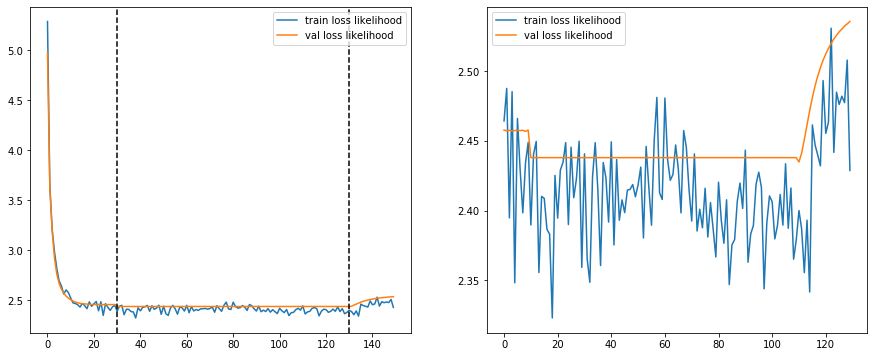

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax[0].plot(train_loss, label='train loss likelihood')
ax[0].plot(val_loss, label='val loss likelihood')
ax[0].legend(loc=1)
ax[0].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
ax[1].plot(train_loss[20:], label='train loss likelihood')
ax[1].plot(val_loss[20:], label='val loss likelihood')
ax[1].legend(loc=2)

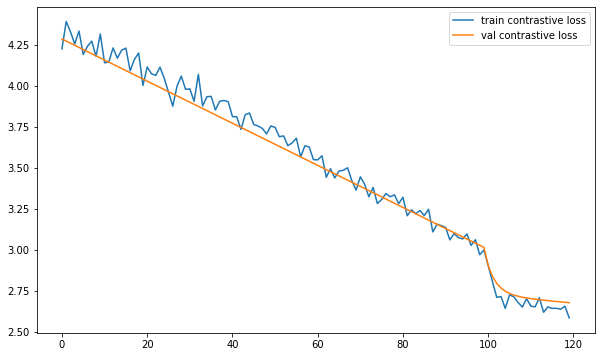

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(train_contr_loss, label='train contrastive loss')
plt.plot(val_contr_loss, label='val contrastive loss')
plt.legend(loc=1);

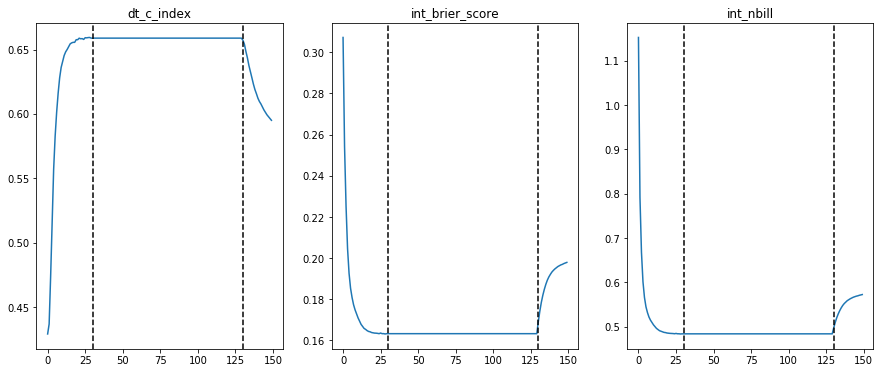

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
ax[0].plot(df_all_q['dt_c_index'].values)
ax[0].set_title('dt_c_index')
ax[0].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
ax[1].plot(df_all_q['int_brier_score'].values)
ax[1].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[1].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
ax[1].set_title('int_brier_score')
ax[2].plot(df_all_q['int_nbill'].values)
ax[2].set_title('int_nbill')
ax[2].axvline(params['n_epochs_binary'], c='black', linestyle='--')
ax[2].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--');

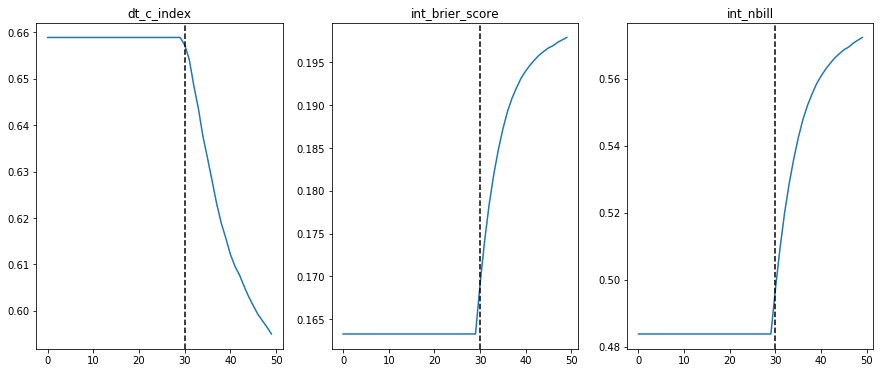

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
ax[0].plot(df_all_q['dt_c_index'].values[100:])
ax[0].set_title('dt_c_index')
ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed']-100, c='black', linestyle='--')
ax[1].plot(df_all_q['int_brier_score'].values[100:])
ax[1].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed']-100, c='black', linestyle='--')
ax[1].set_title('int_brier_score')
ax[2].plot(df_all_q['int_nbill'].values[100:])
ax[2].set_title('int_nbill')
ax[2].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'] - 100, c='black', linestyle='--');

In [62]:
# momentum

In [84]:
def test_hp(train_data, test_data, model_params):
    tf.reset_default_graph()
    model = ContrastiveRankingModel(input_shape=model_params['inp_shape'], seed=model_params['seed'], alpha_reg=model_params['alpha_reg'], 
                                    main_network=metabric_main_network, 
                                    contrastive_weight=model_params['contrastive_weight'], margin_weight=model_params['margin_weight'])
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    ## contrastive data generator
    # validation data
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], 
                                  n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val_contrastive, x_batch_right_val_contrastive], y_batch_val_contrastive, sample_weight_val_contrastive, target_val_contrastive = next(
        dg.get_batch())
    val_size_contrastive = x_batch_left_val_contrastive.shape[0]
    # training data
    dg_contrastive = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])    
    n_batches_contrastive = min(dg_contrastive.ij_pos_sorted.shape[1], dg_contrastive.ij_neg_sorted.shape[1]) // model_params['batch_size']
    n_epochs_contrastive = model_params['n_epochs_contrastive']
    n_epochs_contrastive_freezed = model_params['n_epochs_contrastive_freezed']
    
    ## binary data generator    
    # validation data
    dg = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg_binary = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val_binary, x_batch_right_val_binary], y_batch_val_binary, sample_weight_val_binary, target_val_binary = next(dg.get_batch())
    val_size_binary = x_batch_left_val_binary.shape[0]
    # training data
    dg_binary = BinaryDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])
    n_batches_binary = min(dg_binary.ij_pos_sorted.shape[1], dg_binary.ij_neg_sorted.shape[1]) // model_params['batch_size']
    n_epochs_binary = model_params['n_epochs_binary']
    
    # optimizators
    # cycling learning rate
    all_lr = []
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = cyclic_learning_rate(global_step=global_step, learning_rate=model_params['max_lr'] / 5, max_lr=model_params['max_lr'], 
                                         step_size=model_params['step_size'], mode='triangular2')

    
    all_pred = []
    train_loss = []
    val_loss = []
    train_contr_loss = []
    val_contr_loss = []
    # Launch the graph
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            
            optimizer1 = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            train_op_weibull = optimizer1.minimize(model.main_loss, global_step=global_step, var_list=trainable_binary)
            optimizer3 = tf.train.GradientDescentOptimizer(learning_rate=model_params['learning_rate_contr_freezed'])
            train_op_contrastive_freezed = optimizer3.minimize(model.loss, var_list=trainable_contr)  
            optimizer2 = tf.train.MomentumOptimizer(learning_rate=model_params['learning_rate_contr'], momentum=model_params['momentum'])
            train_op_contrastive = optimizer2.minimize(model.loss, var_list=trainable_contr_binary)
            
            init = tf.initialize_all_variables()
            sess.run(init)
            
            ## train standard weibull loss on binary batch generator
            for i in tqdm(range(n_epochs_binary)):
                # initialize generator
                gen = dg_binary.get_batch()
                # for each batch
                for j in range(n_batches_binary):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }
                    
                    # train model
                    _, l = sess.run([train_op_weibull, model.main_loss], feed_dict=feed_dict)
                    
                 # change learning rate
                assign_op = global_step.assign(i)
                sess.run(assign_op)               
                new_lr = sess.run(optimizer1._learning_rate_tensor)
                all_lr.append(new_lr)
                
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                # save test loss
                l = sess.run([model.main_loss], feed_dict={
                    model.x_a: x_batch_left_val_binary, 
                    model.x_b: x_batch_right_val_binary, 
                    model.t_a: y_batch_val_binary[:, 0].reshape((val_size_binary, 1)),
                    model.t_b: y_batch_val_binary[:, 1].reshape((val_size_binary, 1)),
                    model.y_a: y_batch_val_binary[:, 2].reshape((val_size_binary, 1)),
                    model.y_b: y_batch_val_binary[:, 3].reshape((val_size_binary, 1)),
                    model.target: target_val_binary.reshape((val_size_binary, 1)),
                    model.sample_weight: sample_weight_val_binary
                }) 
                val_loss.append(l)
                

            ## train contrastive loss on contrastive batch generator FREEZED
            for i in tqdm(range(n_epochs_contrastive_freezed)):
                # initialize generator
                gen = dg_contrastive.get_batch()
                # for each batch
                for j in range(n_batches_contrastive):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }
                    
                    # train model
                    _, l, l_c = sess.run([train_op_contrastive_freezed, model.main_loss, model.loss], feed_dict=feed_dict)
              
                 # change learning rate
#                 assign_op = global_step.assign(i)
#                 sess.run(assign_op)               
#                 new_lr = sess.run(optimizer3._learning_rate_tensor)
#                 all_lr.append(new_lr)
                
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                train_contr_loss.append(l_c)
                # save test loss
                l, l_c = sess.run([model.main_loss, model.loss], feed_dict={
                    model.x_a: x_batch_left_val_contrastive, 
                    model.x_b: x_batch_right_val_contrastive, 
                    model.t_a: y_batch_val_contrastive[:, 0].reshape((val_size_contrastive, 1)),
                    model.t_b: y_batch_val_contrastive[:, 1].reshape((val_size_contrastive, 1)),
                    model.y_a: y_batch_val_contrastive[:, 2].reshape((val_size_contrastive, 1)),
                    model.y_b: y_batch_val_contrastive[:, 3].reshape((val_size_contrastive, 1)),
                    model.target: target_val_contrastive.reshape((val_size_contrastive, 1)),
                    model.sample_weight: sample_weight_val_contrastive
                }) 
                val_loss.append(l)     
                val_contr_loss.append(l_c)
                
                
                
                
            ## train contrastive loss on contrastive batch generator
            for i in tqdm(range(n_epochs_contrastive)):
                # initialize generator
                gen = dg_contrastive.get_batch()
                # for each batch
                for j in range(n_batches_contrastive):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }
                    
                    # train model
                    _, l, l_c = sess.run([train_op_contrastive, model.main_loss, model.loss], feed_dict=feed_dict)
              
                 # change learning rate
#                 assign_op = global_step.assign(i)
#                 sess.run(assign_op)               
#                 new_lr = sess.run(optimizer2._learning_rate_tensor)
#                 all_lr.append(new_lr)
                
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                train_contr_loss.append(l_c)
                # save test loss
                l, l_c = sess.run([model.main_loss, model.loss], feed_dict={
                    model.x_a: x_batch_left_val_contrastive, 
                    model.x_b: x_batch_right_val_contrastive, 
                    model.t_a: y_batch_val_contrastive[:, 0].reshape((val_size_contrastive, 1)),
                    model.t_b: y_batch_val_contrastive[:, 1].reshape((val_size_contrastive, 1)),
                    model.y_a: y_batch_val_contrastive[:, 2].reshape((val_size_contrastive, 1)),
                    model.y_b: y_batch_val_contrastive[:, 3].reshape((val_size_contrastive, 1)),
                    model.target: target_val_contrastive.reshape((val_size_contrastive, 1)),
                    model.sample_weight: sample_weight_val_contrastive
                }) 
                val_loss.append(l)     
                val_contr_loss.append(l_c)

    return all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr


In [70]:
def plot_results():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(train_loss, label='train loss likelihood')
    ax[0].plot(val_loss, label='val loss likelihood')
    ax[0].legend(loc=1)
    ax[0].axvline(params['n_epochs_binary'], c='black', linestyle='--')
    ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
    ax[1].plot(train_loss[20:], label='train loss likelihood')
    ax[1].plot(val_loss[20:], label='val loss likelihood')
    ax[1].legend(loc=2)    
    plt.show();
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_contr_loss, label='train contrastive loss')
    plt.plot(val_contr_loss, label='val contrastive loss')
    plt.legend(loc=1)  
    plt.show();
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values)
    ax[0].set_title('dt_c_index')
    ax[0].axvline(params['n_epochs_binary'], c='black', linestyle='--')
    ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values)
    ax[1].axvline(params['n_epochs_binary'], c='black', linestyle='--')
    ax[1].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values)
    ax[2].set_title('int_nbill')
    ax[2].axvline(params['n_epochs_binary'], c='black', linestyle='--')
    ax[2].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
    plt.show();
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values[100:])
    ax[0].set_title('dt_c_index')
    ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed']-100, c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values[100:])
    ax[1].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed']-100, c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values[100:])
    ax[2].set_title('int_nbill')
    ax[2].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'] - 100, c='black', linestyle='--')
    plt.show();

In [76]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive_freezed = 100
n_epochs_contrastive = 100

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive_freezed': n_epochs_contrastive_freezed,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr_freezed': 0.0001,
    'learning_rate_contr': 0.00005,
    'momentum': 0.8
}


In [77]:
batch_size = [1024]
alpha_reg = [1e-6]

contrastive_weight = [0.1]
margin_weight = [0.01]

param_grid = {
    'batch_size': batch_size, 
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': contrastive_weight
}
grid = ParameterGrid(param_grid)

In [73]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
params = grid[0]
tf.reset_default_graph()
params.update(static_params)
all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)

In [74]:
val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]

all_q = []
for pred in all_pred:
    all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
df_all_q = pd.concat(all_q)

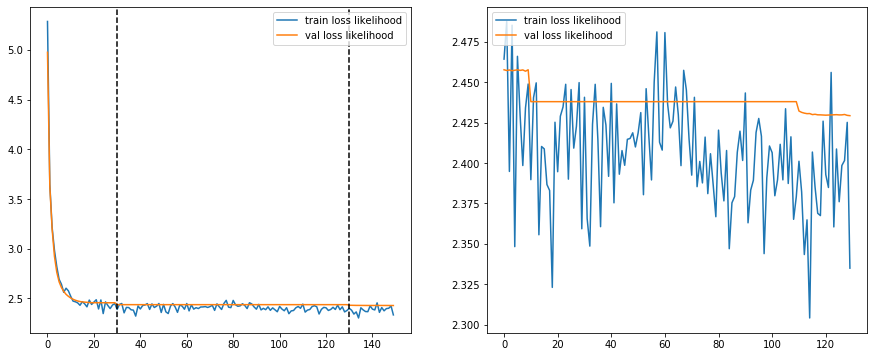

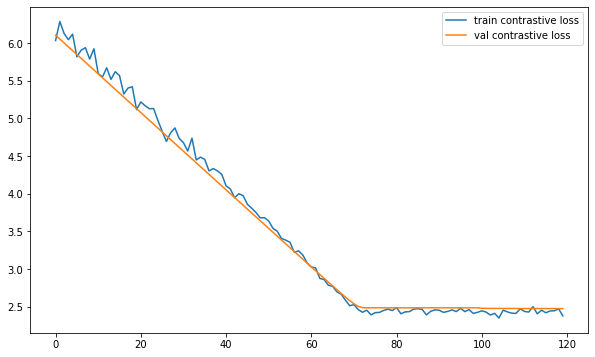

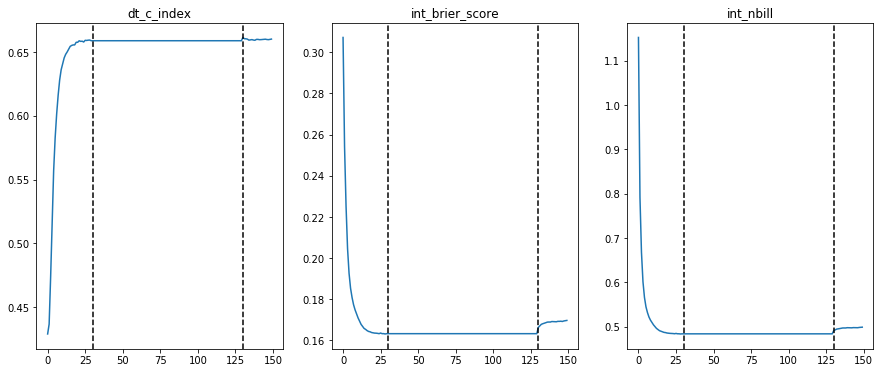

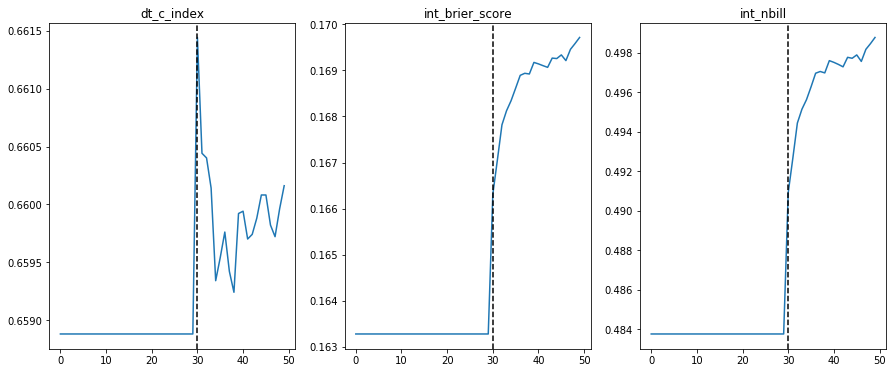

In [75]:
plot_results()

In [ ]:
# n_epochs_contrastive -> 100

In [78]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
params = grid[0]
tf.reset_default_graph()
params.update(static_params)
all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)

In [79]:
val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]

all_q = []
for pred in all_pred:
    all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
df_all_q = pd.concat(all_q)

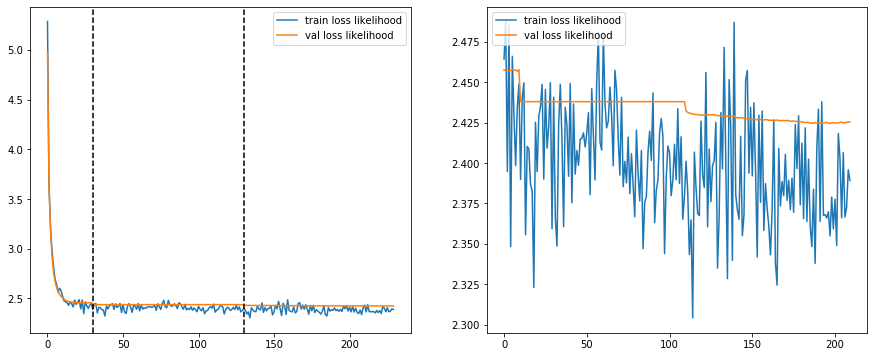

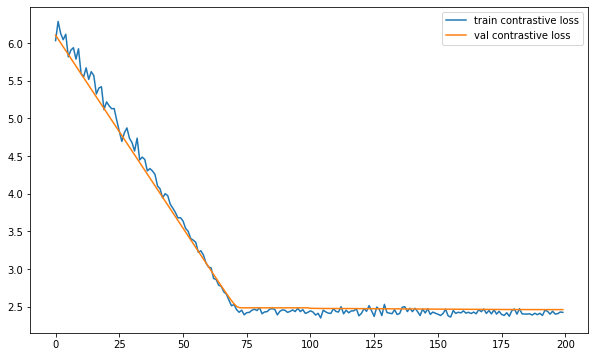

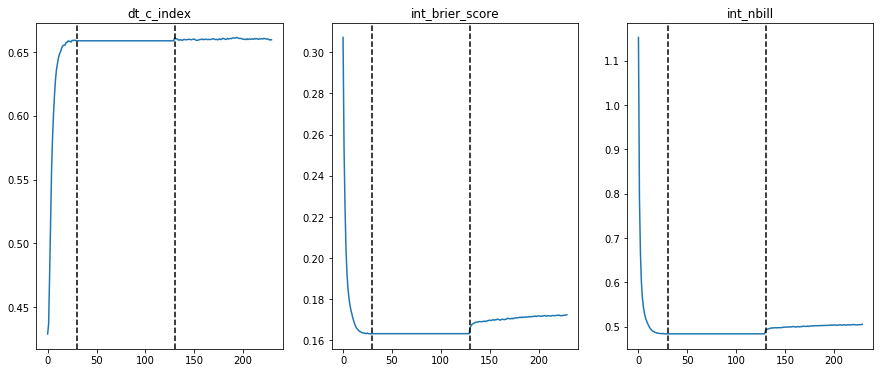

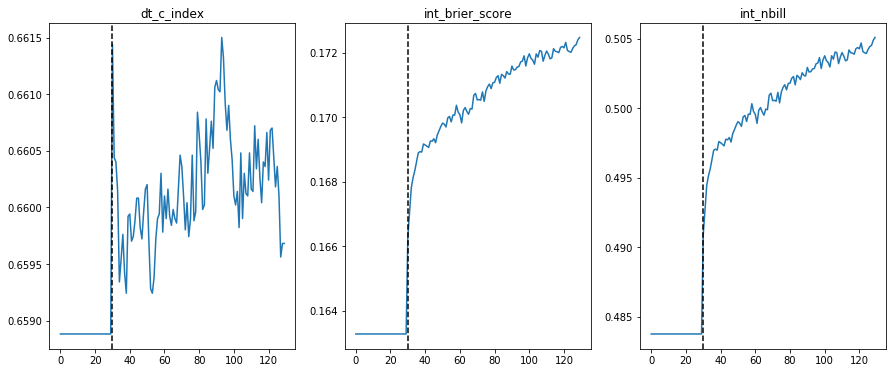

In [80]:
plot_results()

In [82]:
df_all_q.tail(1)

harell_c_index  dt_c_index  int_brier_score  int_nbill
0        0.658902    0.659682         0.172477   0.505097

In [ ]:
# больше momentum

In [85]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive_freezed = 100
n_epochs_contrastive = 100

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive_freezed': n_epochs_contrastive_freezed,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr_freezed': 0.0001,
    'learning_rate_contr': 0.00005,
    'momentum': 0.9
}


In [86]:
batch_size = [1024]
alpha_reg = [1e-6]

contrastive_weight = [0.1]
margin_weight = [0.01]

param_grid = {
    'batch_size': batch_size, 
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': contrastive_weight
}
grid = ParameterGrid(param_grid)

In [87]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
params = grid[0]
tf.reset_default_graph()
params.update(static_params)
all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)

In [88]:
val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]

all_q = []
for pred in all_pred:
    all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
df_all_q = pd.concat(all_q)

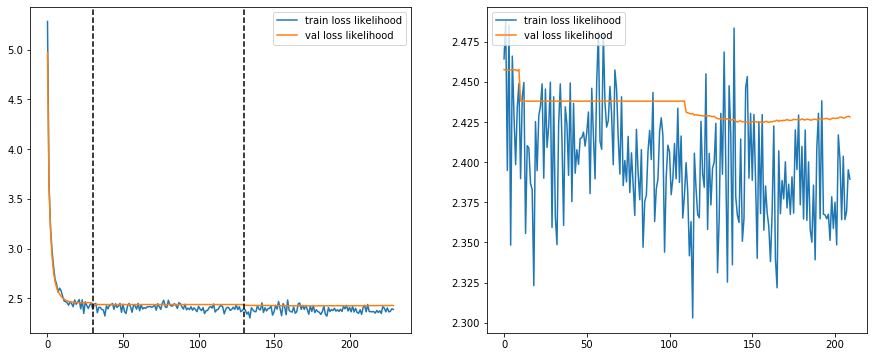

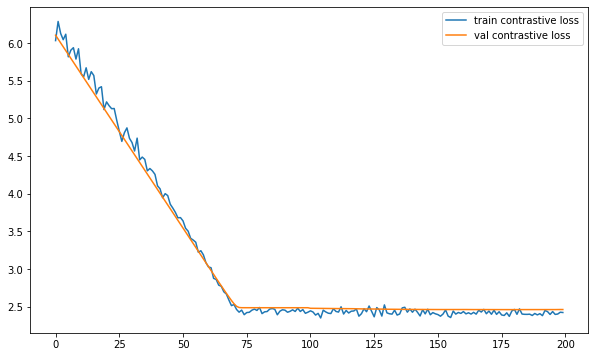

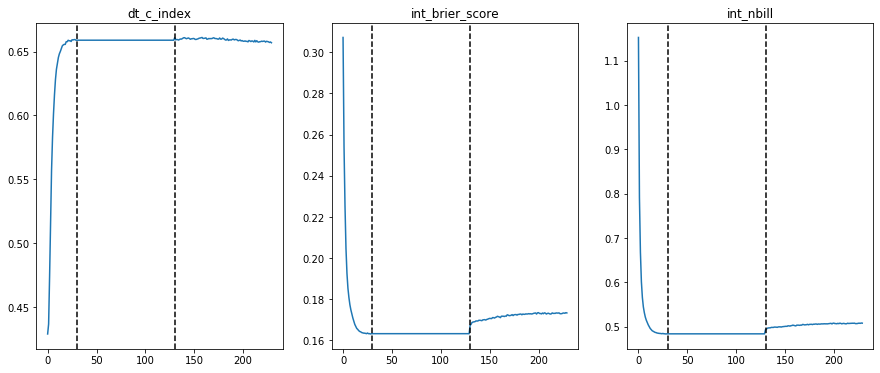

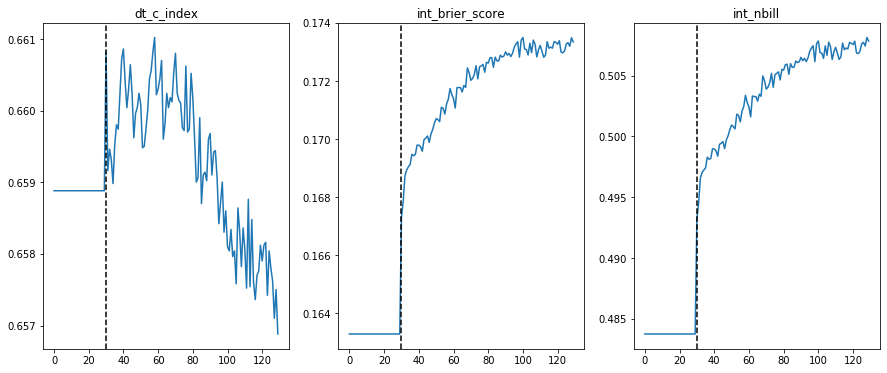

In [89]:
plot_results()

In [90]:
df_all_q.tail(1)

harell_c_index  dt_c_index  int_brier_score  int_nbill
0        0.657062    0.656882         0.173347    0.50785

In [ ]:
# меньше momentum

In [91]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive_freezed = 100
n_epochs_contrastive = 100

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive_freezed': n_epochs_contrastive_freezed,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr_freezed': 0.0001,
    'learning_rate_contr': 0.00005,
    'momentum': 0.7
}


In [92]:
batch_size = [1024]
alpha_reg = [1e-6]

contrastive_weight = [0.1]
margin_weight = [0.01]

param_grid = {
    'batch_size': batch_size, 
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': contrastive_weight
}
grid = ParameterGrid(param_grid)

In [93]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
params = grid[0]
tf.reset_default_graph()
params.update(static_params)
all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)

In [94]:
val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]

all_q = []
for pred in all_pred:
    all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
df_all_q = pd.concat(all_q)

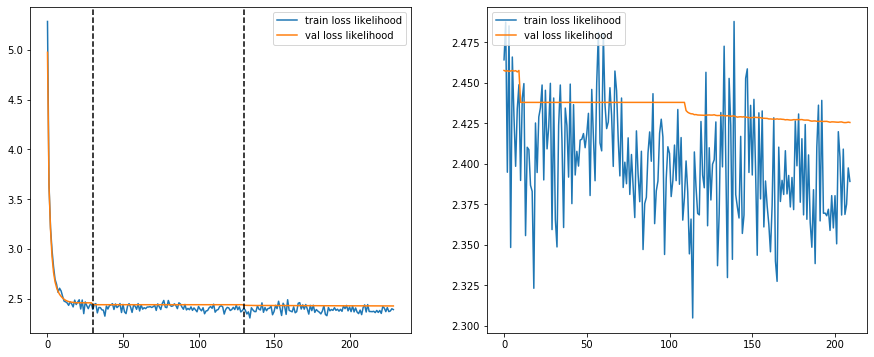

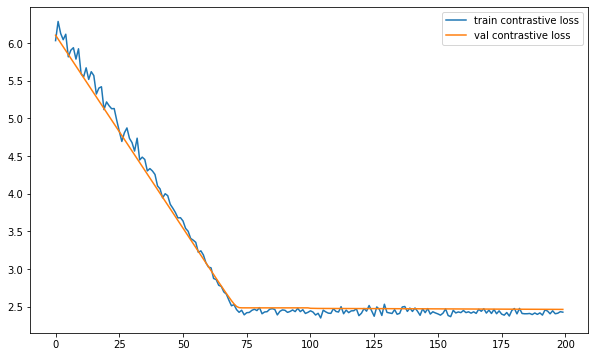

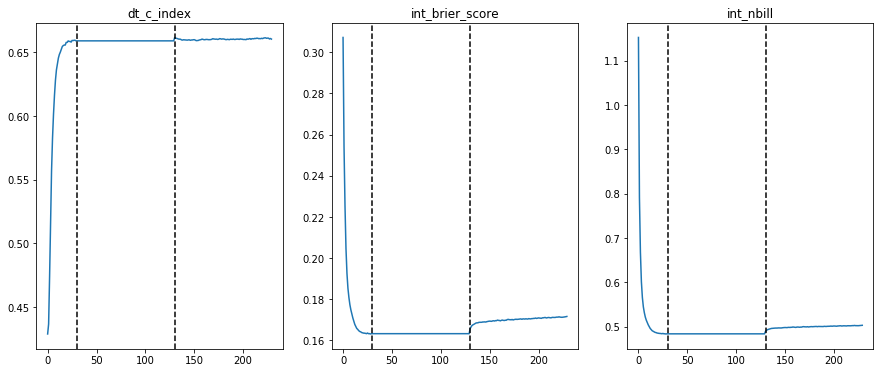

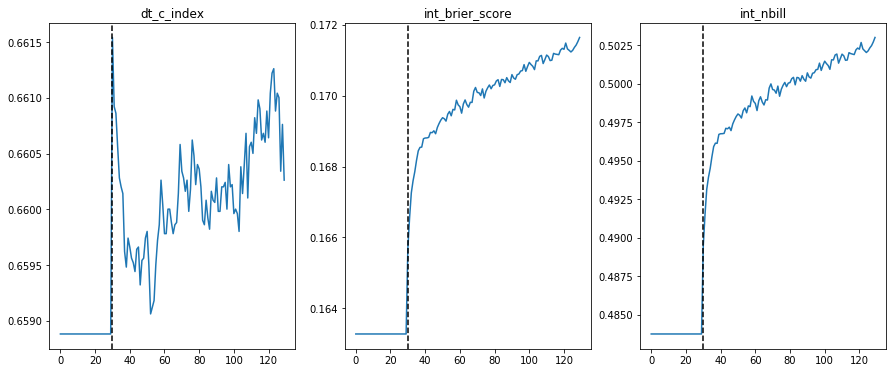

In [95]:
plot_results()

In [96]:
df_all_q.tail(1)

harell_c_index  dt_c_index  int_brier_score  int_nbill
0        0.659542    0.660262         0.171642   0.503002

In [ ]:
# batch size 1024 -> 2048 

In [101]:
def test_hp(train_data, test_data, model_params):
    tf.reset_default_graph()
    model = ContrastiveRankingModel(input_shape=model_params['inp_shape'], seed=model_params['seed'], alpha_reg=model_params['alpha_reg'], 
                                    main_network=metabric_main_network, 
                                    contrastive_weight=model_params['contrastive_weight'], margin_weight=model_params['margin_weight'])
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    ## contrastive data generator
    # validation data
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size_contr'], 
                                  n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val_contrastive, x_batch_right_val_contrastive], y_batch_val_contrastive, sample_weight_val_contrastive, target_val_contrastive = next(
        dg.get_batch())
    val_size_contrastive = x_batch_left_val_contrastive.shape[0]
    # training data
    dg_contrastive = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size_contr'],
                             n_time_bins=model_params['n_time_bins'])    
    n_batches_contrastive = min(dg_contrastive.ij_pos_sorted.shape[1], dg_contrastive.ij_neg_sorted.shape[1]) // model_params['batch_size_contr']
    
    
    n_epochs_contrastive = model_params['n_epochs_contrastive']
    n_epochs_contrastive_freezed = model_params['n_epochs_contrastive_freezed']
    
    ## binary data generator    
    # validation data
    dg = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg_binary = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val_binary, x_batch_right_val_binary], y_batch_val_binary, sample_weight_val_binary, target_val_binary = next(dg.get_batch())
    val_size_binary = x_batch_left_val_binary.shape[0]
    # training data
    dg_binary = BinaryDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])
    n_batches_binary = min(dg_binary.ij_pos_sorted.shape[1], dg_binary.ij_neg_sorted.shape[1]) // model_params['batch_size']
    n_epochs_binary = model_params['n_epochs_binary']
    
    # optimizators
    # cycling learning rate
    all_lr = []
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = cyclic_learning_rate(global_step=global_step, learning_rate=model_params['max_lr'] / 5, max_lr=model_params['max_lr'], 
                                         step_size=model_params['step_size'], mode='triangular2')

    
    all_pred = []
    train_loss = []
    val_loss = []
    train_contr_loss = []
    val_contr_loss = []
    # Launch the graph
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            
            optimizer1 = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            train_op_weibull = optimizer1.minimize(model.main_loss, global_step=global_step, var_list=trainable_binary)
            optimizer3 = tf.train.GradientDescentOptimizer(learning_rate=model_params['learning_rate_contr_freezed'])
            train_op_contrastive_freezed = optimizer3.minimize(model.loss, var_list=trainable_contr)  
            optimizer2 = tf.train.MomentumOptimizer(learning_rate=model_params['learning_rate_contr'], momentum=model_params['momentum'])
            train_op_contrastive = optimizer2.minimize(model.loss, var_list=trainable_contr_binary)
            
            init = tf.initialize_all_variables()
            sess.run(init)
            
            ## train standard weibull loss on binary batch generator
            for i in tqdm(range(n_epochs_binary)):
                # initialize generator
                gen = dg_binary.get_batch()
                # for each batch
                for j in range(n_batches_binary):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }
                    
                    # train model
                    _, l = sess.run([train_op_weibull, model.main_loss], feed_dict=feed_dict)
                    
                 # change learning rate
                assign_op = global_step.assign(i)
                sess.run(assign_op)               
                new_lr = sess.run(optimizer1._learning_rate_tensor)
                all_lr.append(new_lr)
                
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                # save test loss
                l = sess.run([model.main_loss], feed_dict={
                    model.x_a: x_batch_left_val_binary, 
                    model.x_b: x_batch_right_val_binary, 
                    model.t_a: y_batch_val_binary[:, 0].reshape((val_size_binary, 1)),
                    model.t_b: y_batch_val_binary[:, 1].reshape((val_size_binary, 1)),
                    model.y_a: y_batch_val_binary[:, 2].reshape((val_size_binary, 1)),
                    model.y_b: y_batch_val_binary[:, 3].reshape((val_size_binary, 1)),
                    model.target: target_val_binary.reshape((val_size_binary, 1)),
                    model.sample_weight: sample_weight_val_binary
                }) 
                val_loss.append(l)
                

            ## train contrastive loss on contrastive batch generator FREEZED
            for i in tqdm(range(n_epochs_contrastive_freezed)):
                # initialize generator
                gen = dg_contrastive.get_batch()
                # for each batch
                for j in range(n_batches_contrastive):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size_contr'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size_contr'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size_contr'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size_contr'], 1)),
                        model.target: target.reshape((model_params['batch_size_contr'], 1)),
                        model.sample_weight: sample_weight
                    }
                    
                    # train model
                    _, l, l_c = sess.run([train_op_contrastive_freezed, model.main_loss, model.loss], feed_dict=feed_dict)
              
                 # change learning rate
#                 assign_op = global_step.assign(i)
#                 sess.run(assign_op)               
#                 new_lr = sess.run(optimizer3._learning_rate_tensor)
#                 all_lr.append(new_lr)
                
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                train_contr_loss.append(l_c)
                # save test loss
                l, l_c = sess.run([model.main_loss, model.loss], feed_dict={
                    model.x_a: x_batch_left_val_contrastive, 
                    model.x_b: x_batch_right_val_contrastive, 
                    model.t_a: y_batch_val_contrastive[:, 0].reshape((val_size_contrastive, 1)),
                    model.t_b: y_batch_val_contrastive[:, 1].reshape((val_size_contrastive, 1)),
                    model.y_a: y_batch_val_contrastive[:, 2].reshape((val_size_contrastive, 1)),
                    model.y_b: y_batch_val_contrastive[:, 3].reshape((val_size_contrastive, 1)),
                    model.target: target_val_contrastive.reshape((val_size_contrastive, 1)),
                    model.sample_weight: sample_weight_val_contrastive
                }) 
                val_loss.append(l)     
                val_contr_loss.append(l_c)
                
                
                
                
            ## train contrastive loss on contrastive batch generator
            for i in tqdm(range(n_epochs_contrastive)):
                # initialize generator
                gen = dg_contrastive.get_batch()
                # for each batch
                for j in range(n_batches_contrastive):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size_contr'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size_contr'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size_contr'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size_contr'], 1)),
                        model.target: target.reshape((model_params['batch_size_contr'], 1)),
                        model.sample_weight: sample_weight
                    }
                    
                    # train model
                    _, l, l_c = sess.run([train_op_contrastive, model.main_loss, model.loss], feed_dict=feed_dict)
              
                 # change learning rate
#                 assign_op = global_step.assign(i)
#                 sess.run(assign_op)               
#                 new_lr = sess.run(optimizer2._learning_rate_tensor)
#                 all_lr.append(new_lr)
                
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                train_contr_loss.append(l_c)
                # save test loss
                l, l_c = sess.run([model.main_loss, model.loss], feed_dict={
                    model.x_a: x_batch_left_val_contrastive, 
                    model.x_b: x_batch_right_val_contrastive, 
                    model.t_a: y_batch_val_contrastive[:, 0].reshape((val_size_contrastive, 1)),
                    model.t_b: y_batch_val_contrastive[:, 1].reshape((val_size_contrastive, 1)),
                    model.y_a: y_batch_val_contrastive[:, 2].reshape((val_size_contrastive, 1)),
                    model.y_b: y_batch_val_contrastive[:, 3].reshape((val_size_contrastive, 1)),
                    model.target: target_val_contrastive.reshape((val_size_contrastive, 1)),
                    model.sample_weight: sample_weight_val_contrastive
                }) 
                val_loss.append(l)     
                val_contr_loss.append(l_c)

    return all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr


In [102]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive_freezed = 100
n_epochs_contrastive = 100

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive_freezed': n_epochs_contrastive_freezed,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr_freezed': 0.0001,
    'learning_rate_contr': 0.00005,
    'momentum': 0.7
}


In [103]:
batch_size = [1024]
alpha_reg = [1e-6]
batch_size_contr = [2048]

contrastive_weight = [0.1]
margin_weight = [0.01]

param_grid = {
    'batch_size': batch_size,
    'batch_size_contr': batch_size_contr,
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': contrastive_weight
}
grid = ParameterGrid(param_grid)

In [104]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
params = grid[0]
tf.reset_default_graph()
params.update(static_params)
all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)

In [105]:
val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]

all_q = []
for pred in all_pred:
    all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
df_all_q = pd.concat(all_q)

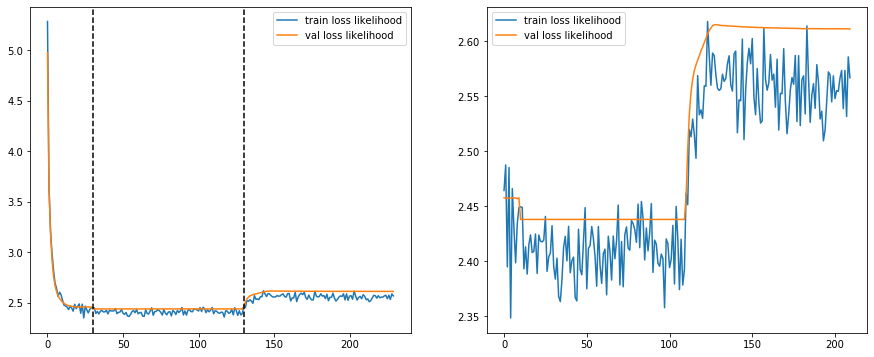

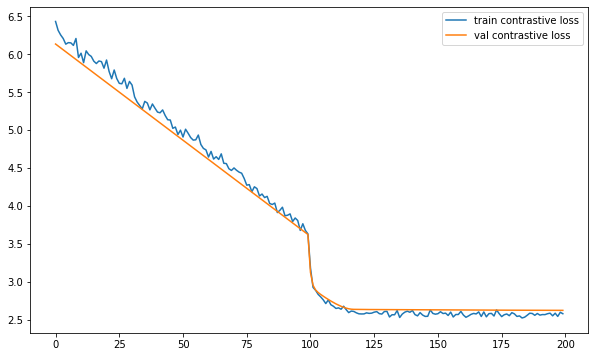

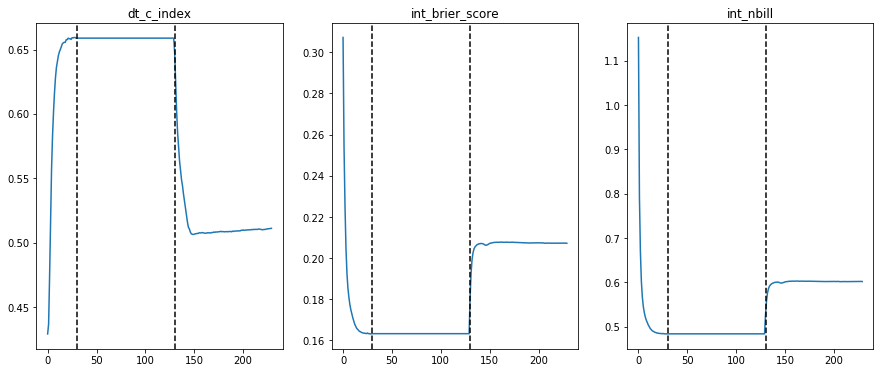

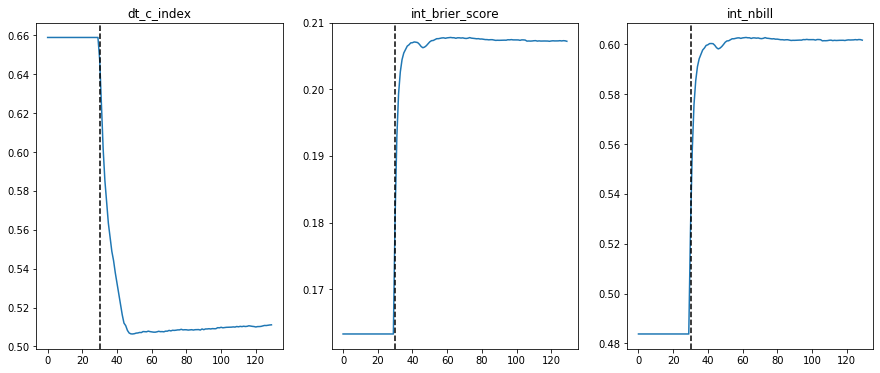

In [106]:
plot_results()

In [107]:
df_all_q.tail(1)

harell_c_index  dt_c_index  int_brier_score  int_nbill
0        0.481684    0.511097         0.207205   0.601737

In [40]:
# переберем сетку по contrastive loss и margin loss и сделаем больше n_epochs_contrastive (20 -> 40)

In [108]:
batch_size = [1024]
alpha_reg = [1e-6]
batch_size_contr = [2048]

contrastive_weight = [0.1]
margin_weight = [0.01]

param_grid = {
    'batch_size': batch_size,
    'batch_size_contr': batch_size_contr,
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': contrastive_weight
}
grid = ParameterGrid(param_grid)

In [109]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive_freezed = 100
n_epochs_contrastive = 40

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive_freezed': n_epochs_contrastive_freezed,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr_freezed': 0.0001,
    'learning_rate_contr': 0.00005,
    'momentum': 0.7
}


In [118]:
batch_size = [1024]
alpha_reg = [1e-6]
batch_size_contr = [1024]
margin_weight = [1e-1]

param_grid = {
    'batch_size': batch_size, 
    'batch_size_contr': batch_size_contr,
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': [0.1, 0.5, 1, 2, 5]
#     'contrastive_weight': np.logspace(-3, 0, 4)
}
grid = ParameterGrid(param_grid)

In [119]:
from collections import namedtuple


margin_weight:  0.001
contrastive_weight:  0.001


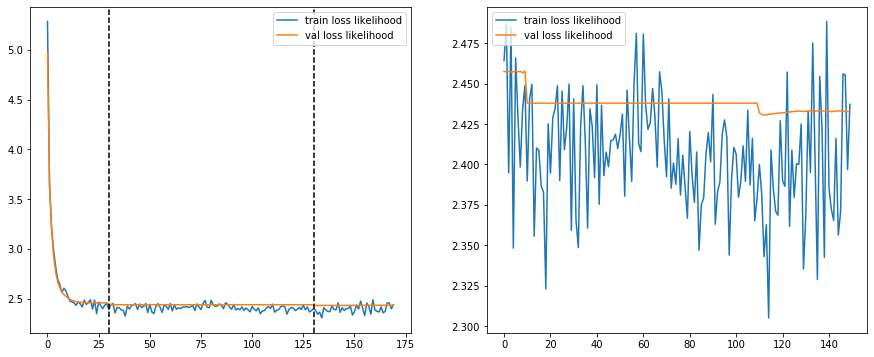

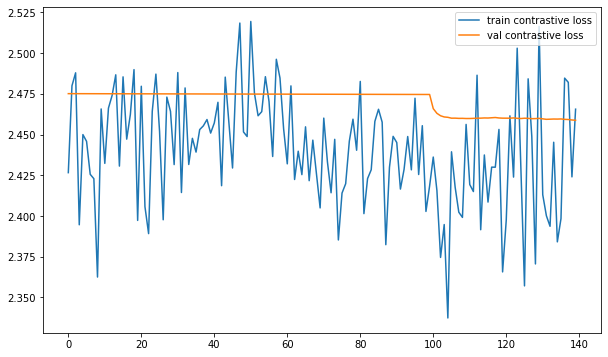

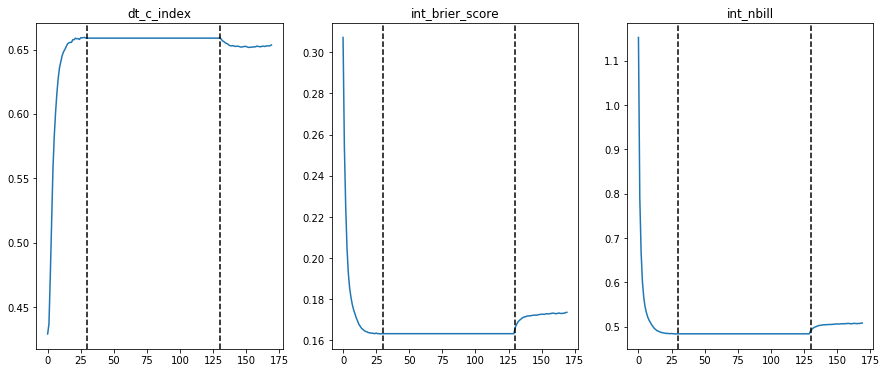

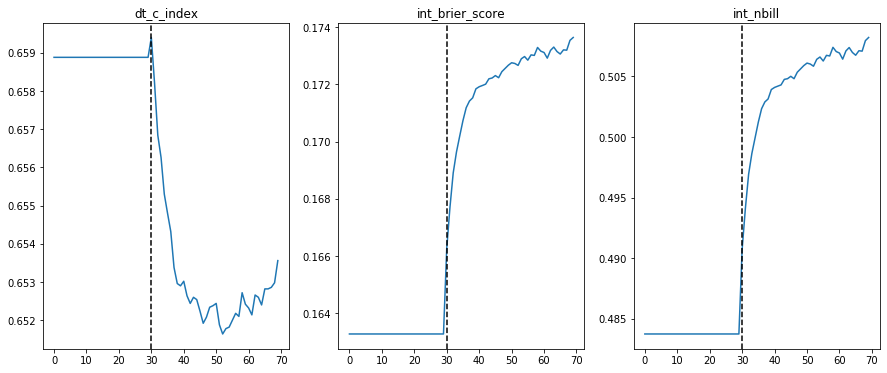


margin_weight:  0.01
contrastive_weight:  0.001


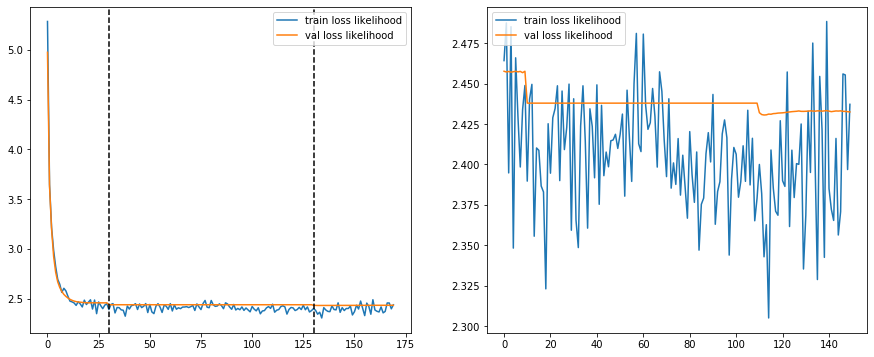

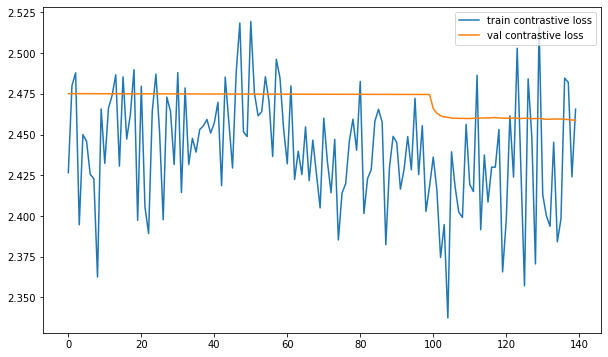

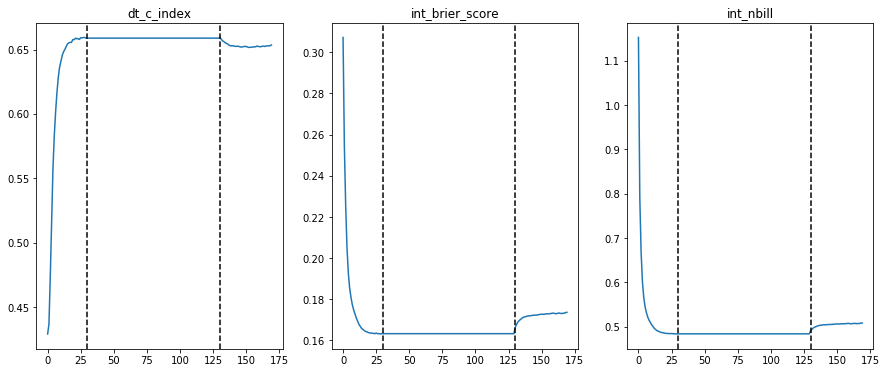

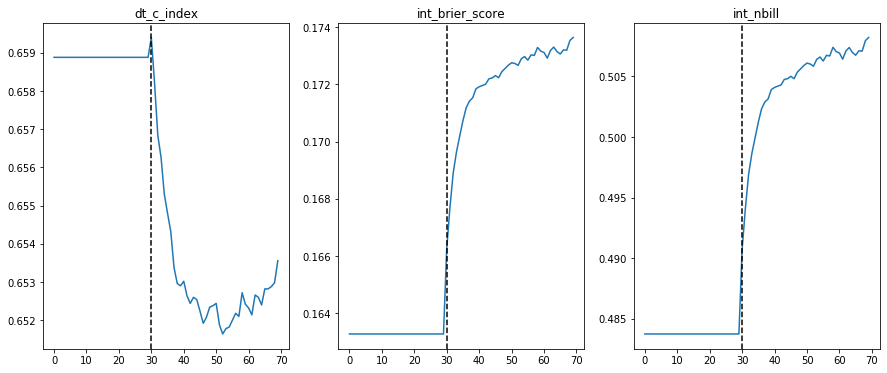


margin_weight:  0.1
contrastive_weight:  0.001


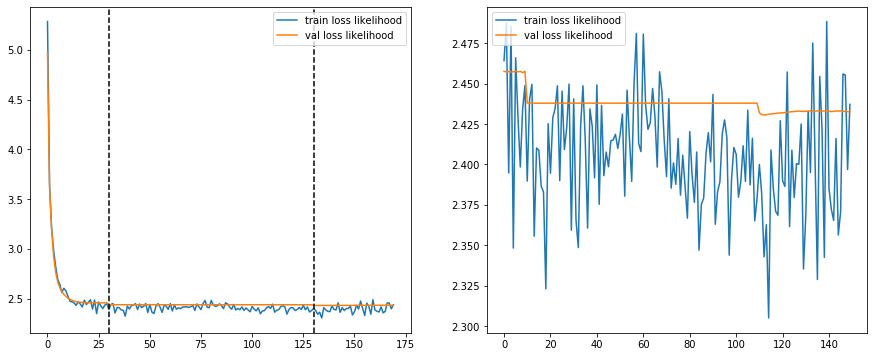

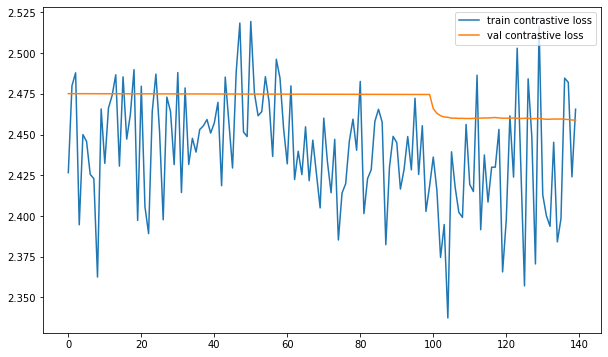

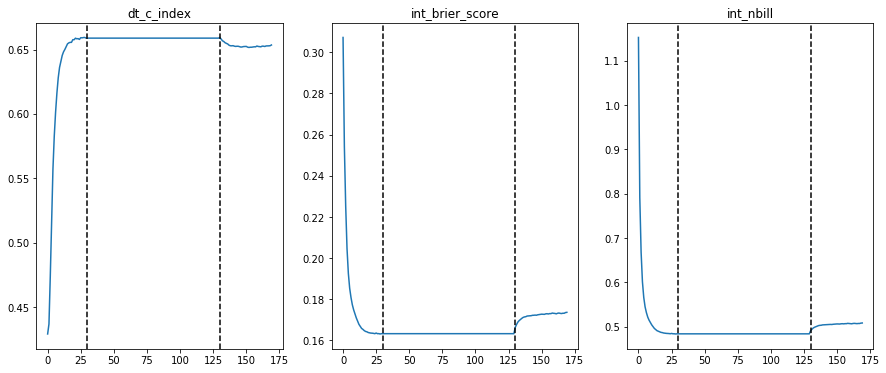

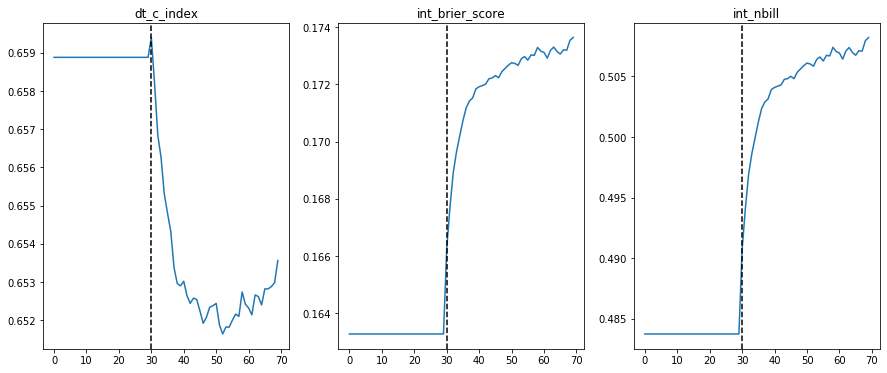


margin_weight:  1.0
contrastive_weight:  0.001


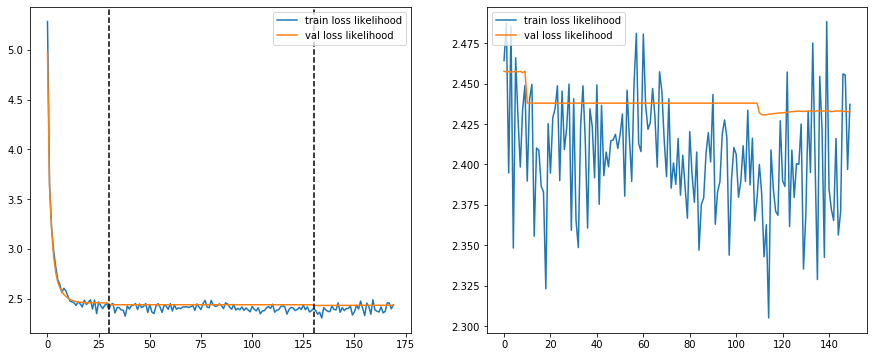

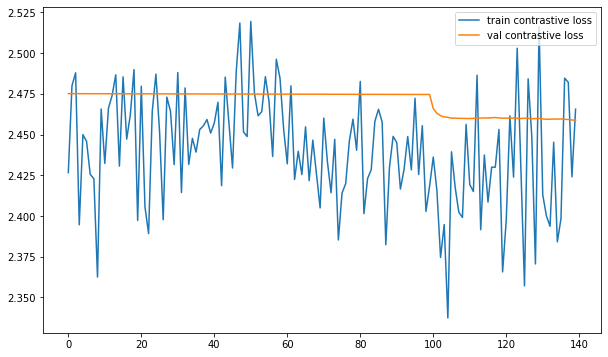

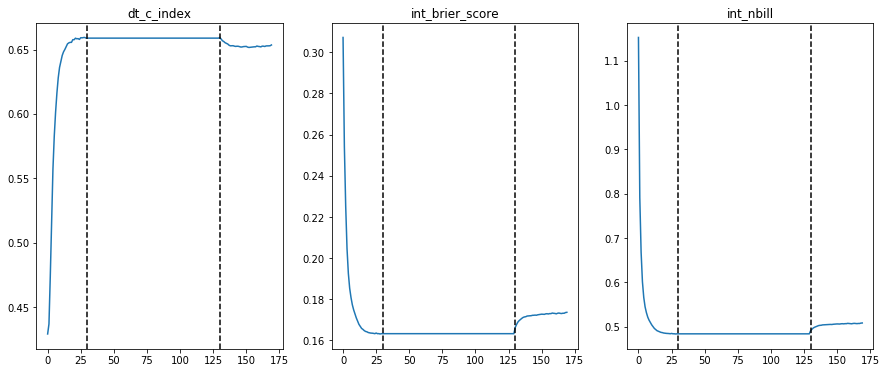

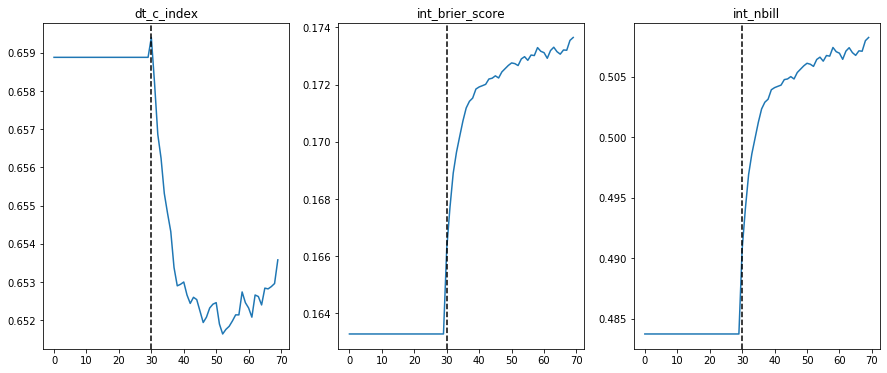


margin_weight:  10.0
contrastive_weight:  0.001


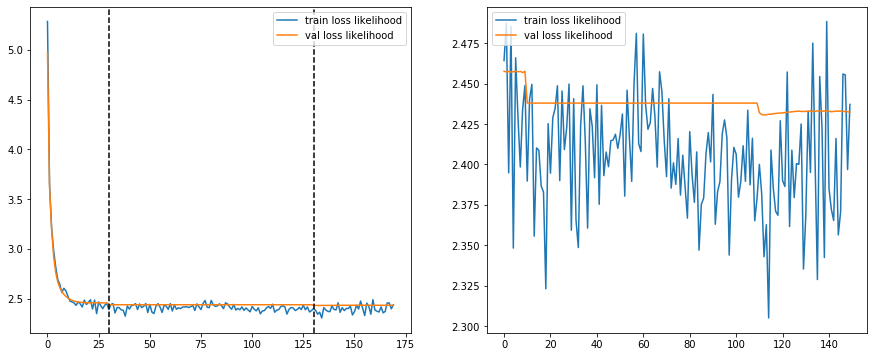

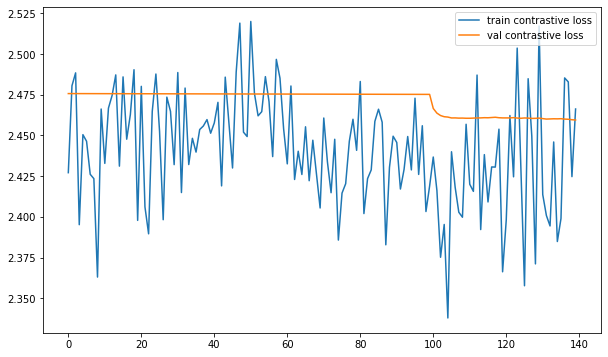

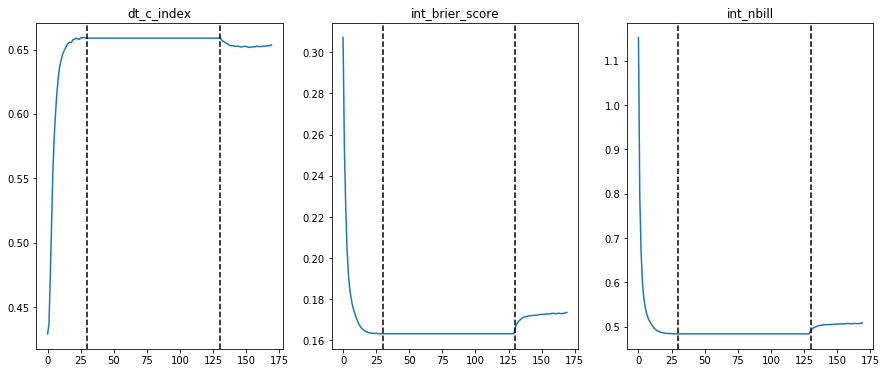

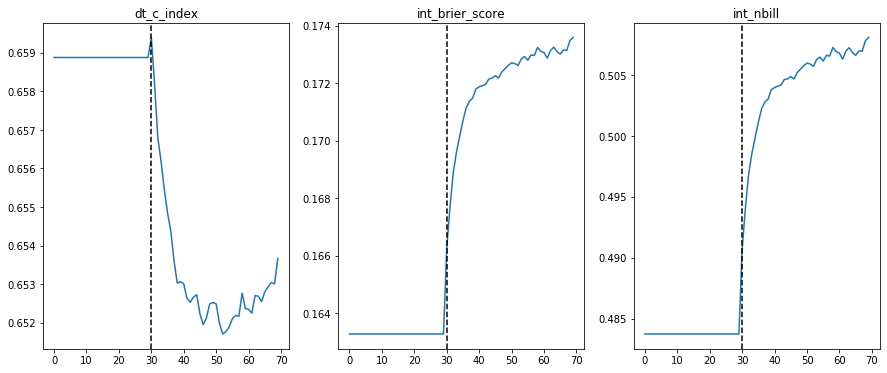


margin_weight:  0.001
contrastive_weight:  0.01


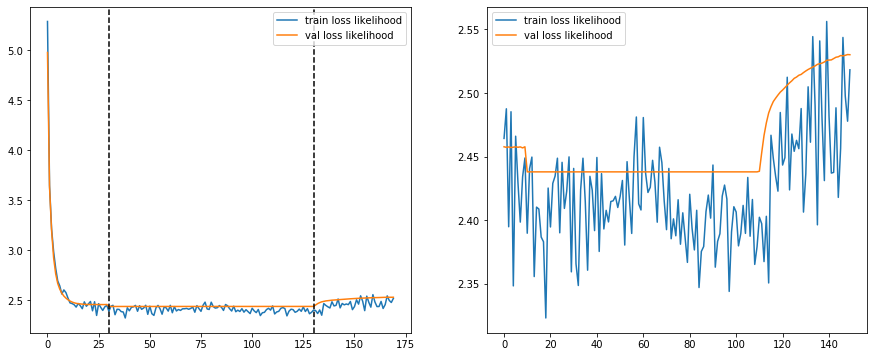

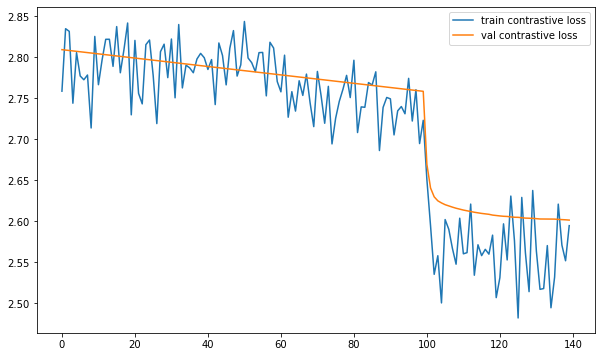

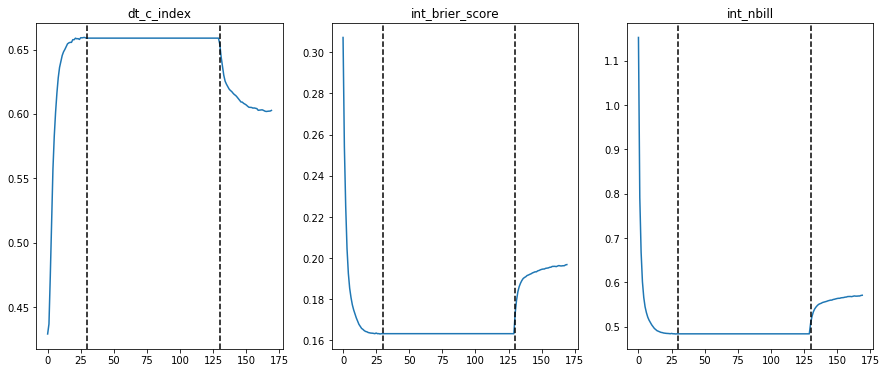

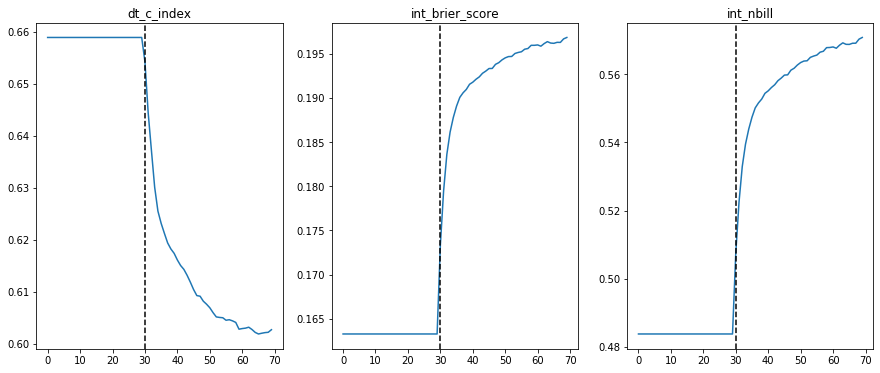


margin_weight:  0.01
contrastive_weight:  0.01


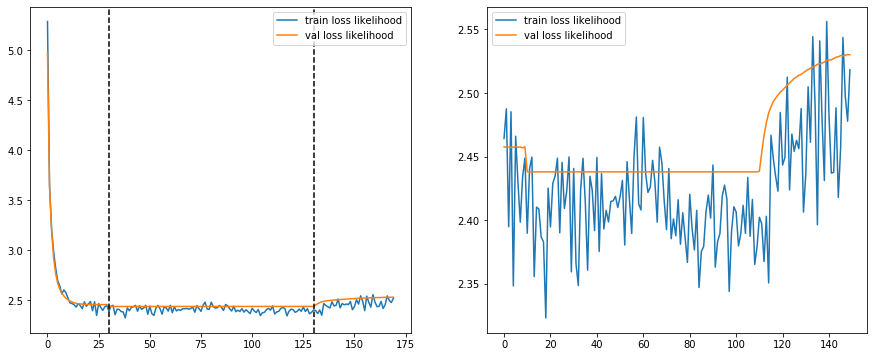

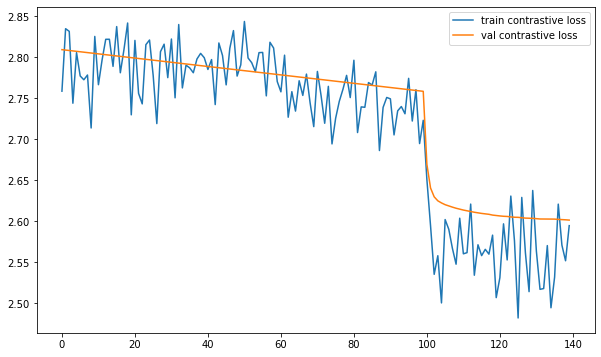

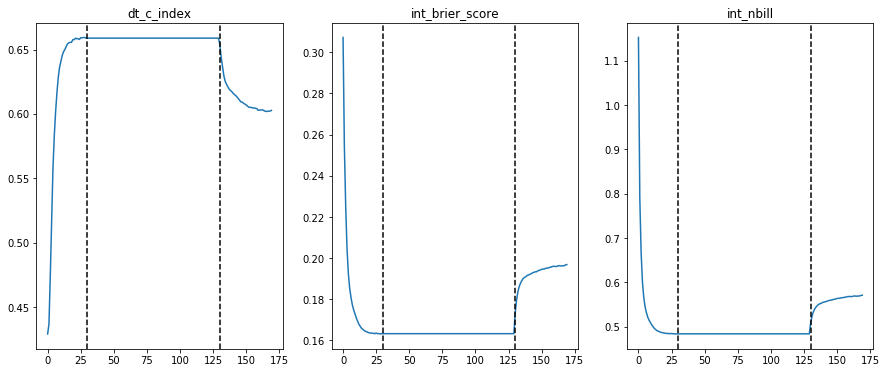

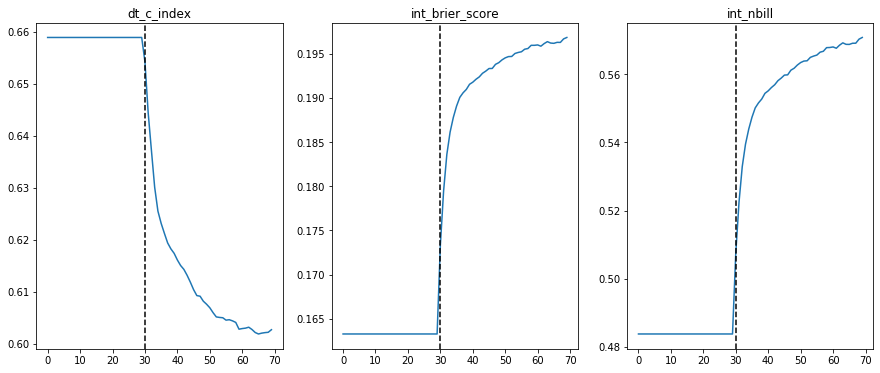

KeyboardInterrupt: 

In [112]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
all_res = []
Output = namedtuple('Output', 'margin_weight contrastive_weight train_loss val_loss train_contr_loss val_contr_loss df_all_q all_pred all_lr')
for params in tqdm(grid):
    tf.reset_default_graph()
    params.update(static_params)
    all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)
    val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]
    all_q = []
    for pred in all_pred:
        all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
    df_all_q = pd.concat(all_q)
    
    res = Output(params['margin_weight'], params['contrastive_weight'], train_loss, val_loss, train_contr_loss, val_contr_loss, df_all_q, all_pred, all_lr)
    all_res.append(res)
    print("margin_weight: ", params['margin_weight'])
    print("contrastive_weight: ", params['contrastive_weight'])
    plot_results()


margin_weight:  0.1
contrastive_weight:  0.1


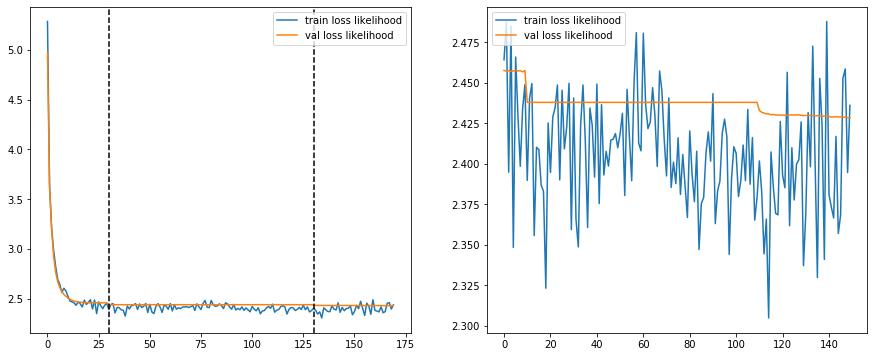

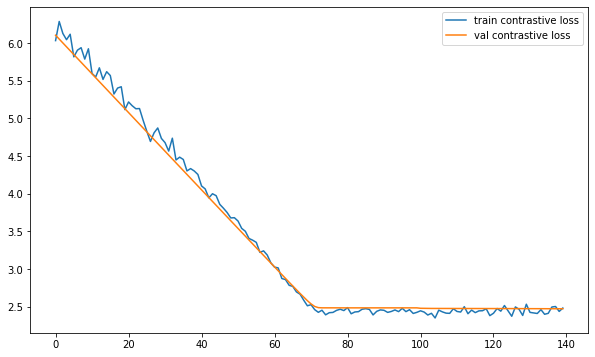

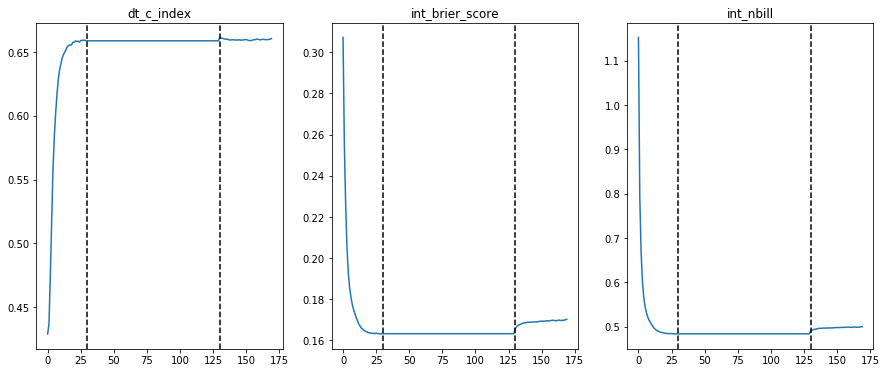

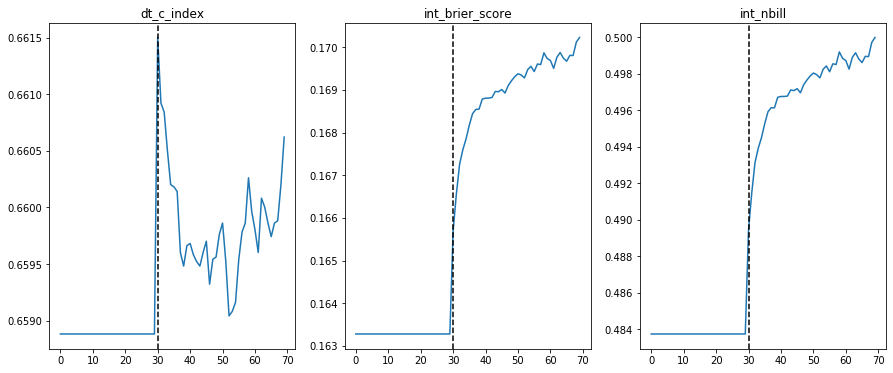


margin_weight:  0.1
contrastive_weight:  0.5


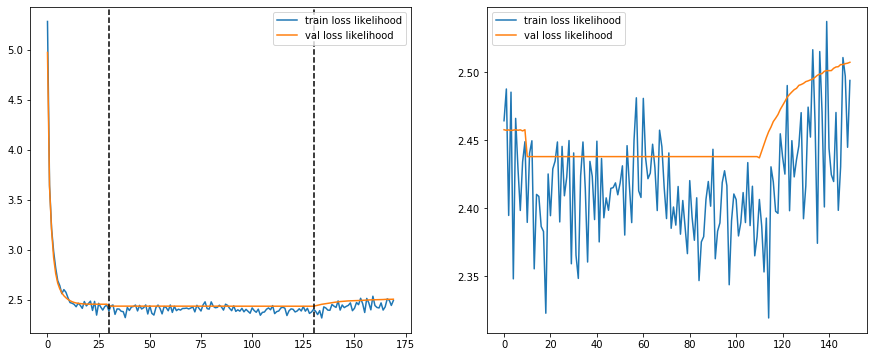

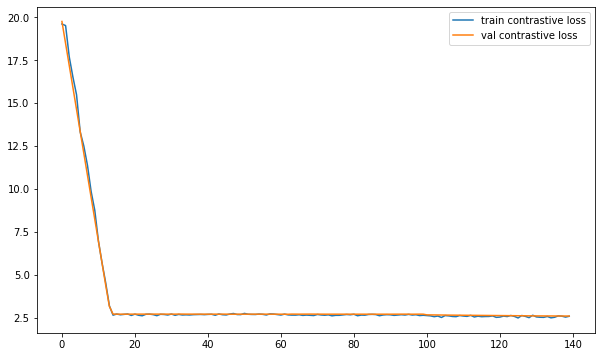

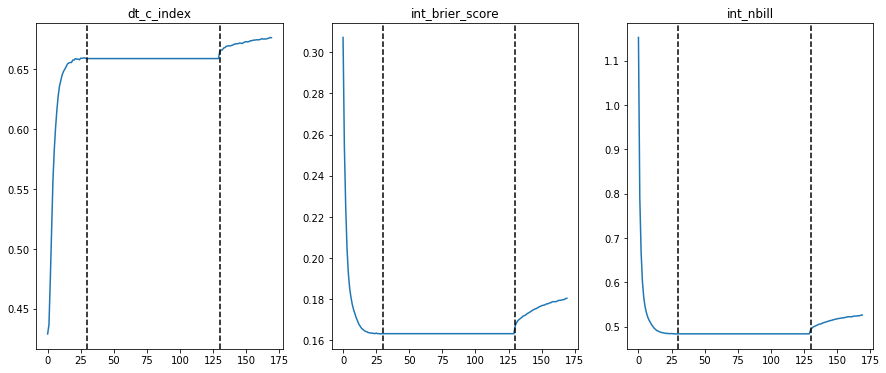

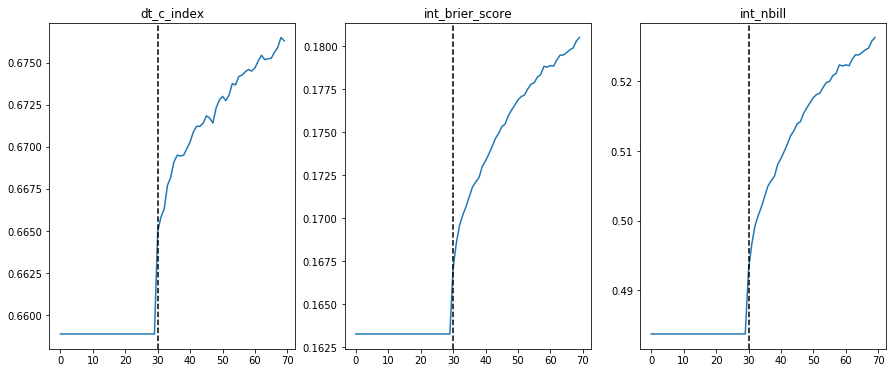


margin_weight:  0.1
contrastive_weight:  1


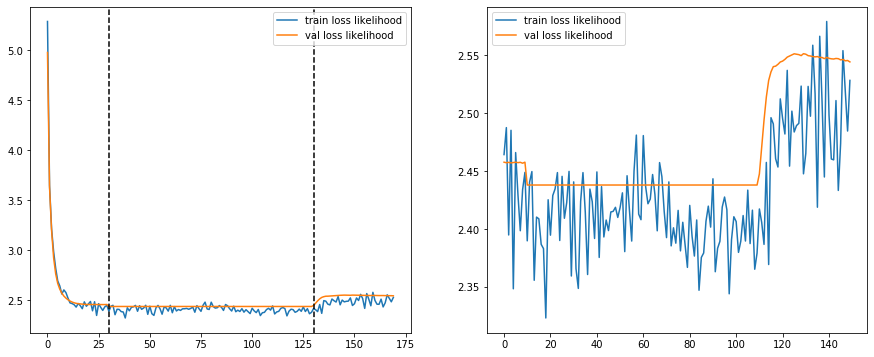

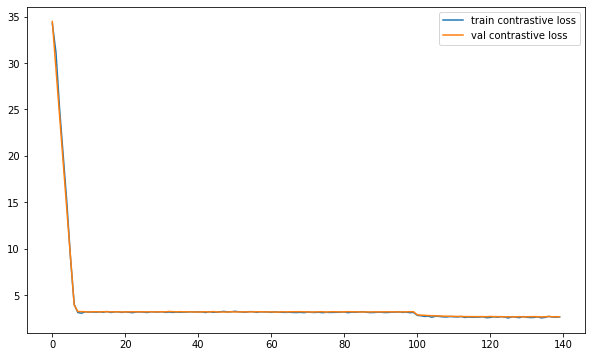

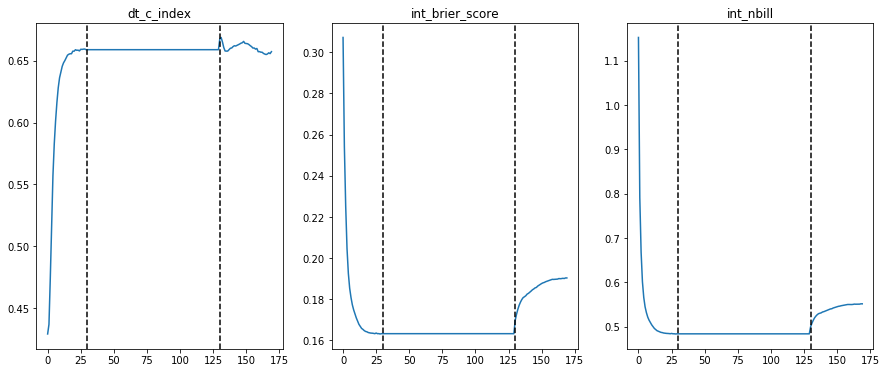

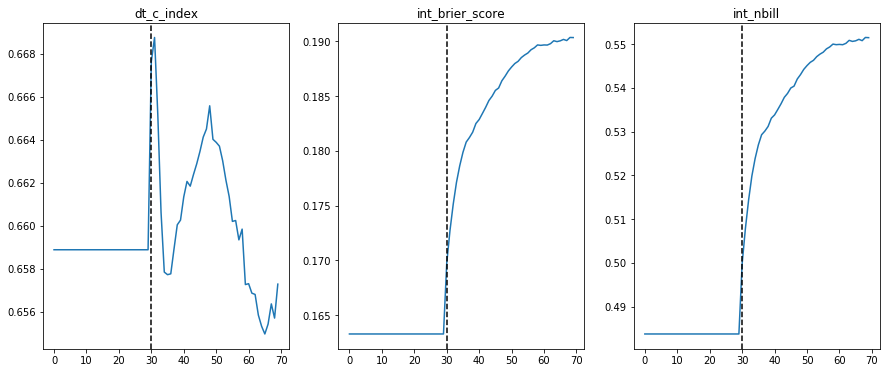


margin_weight:  0.1
contrastive_weight:  2


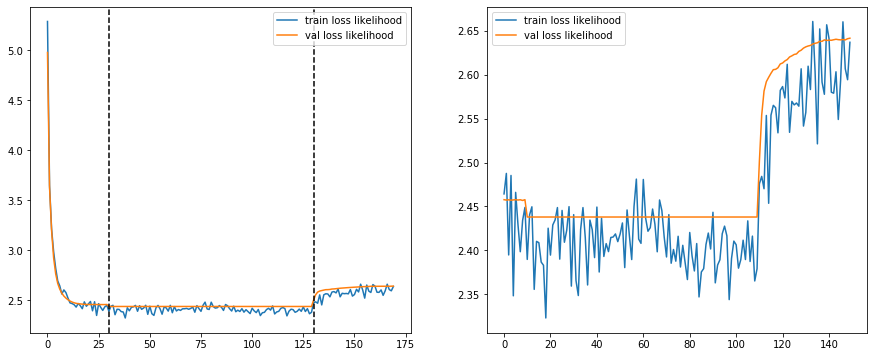

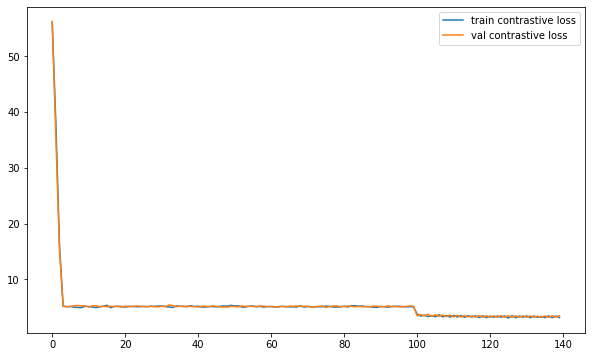

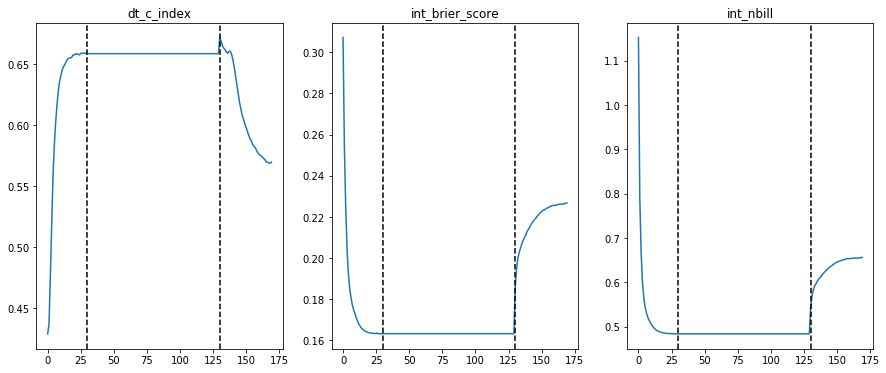

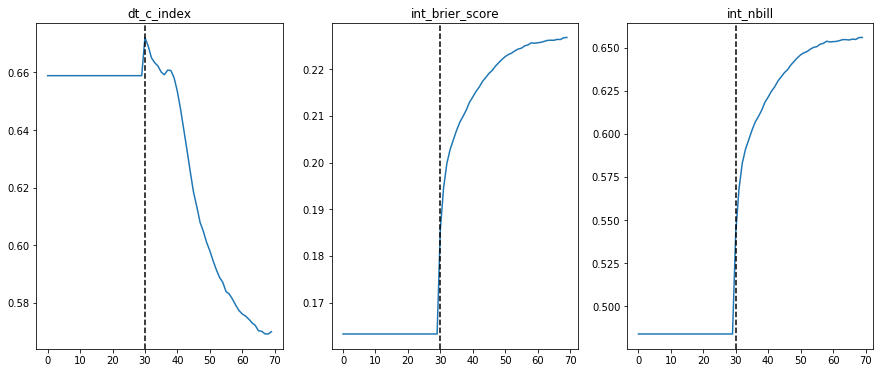


margin_weight:  0.1
contrastive_weight:  5


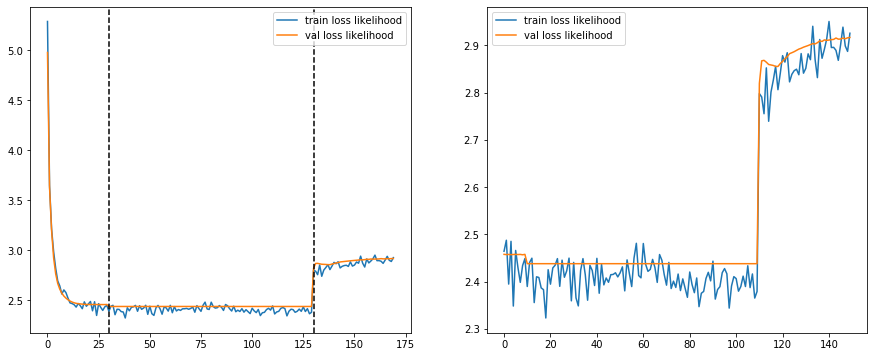

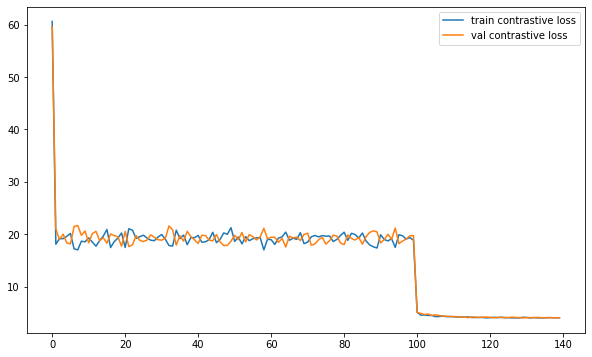

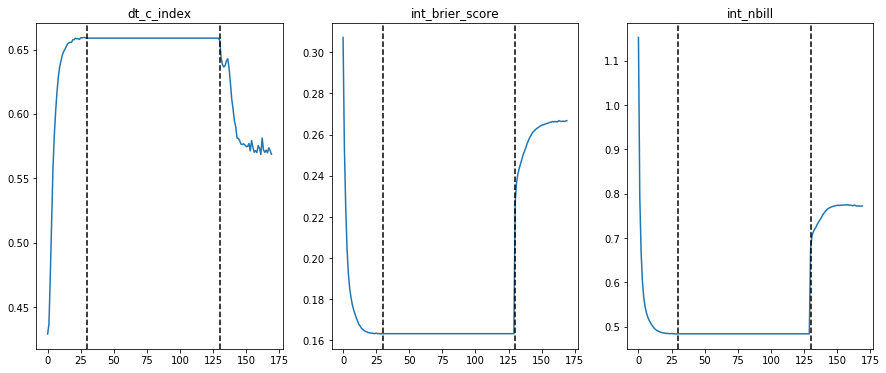

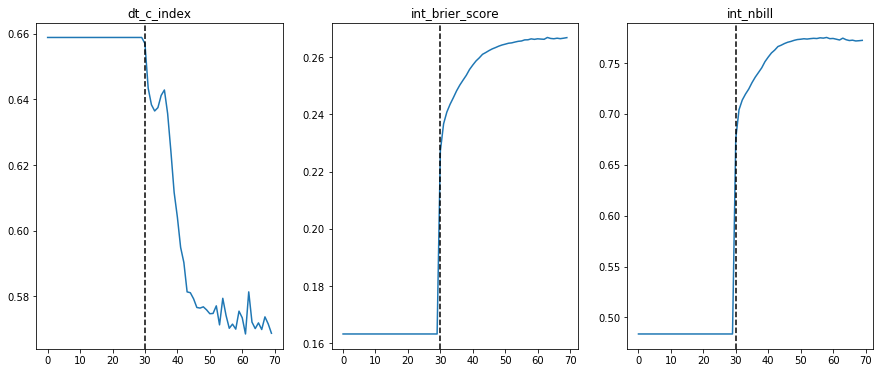

In [120]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
all_res = []
Output = namedtuple('Output', 'margin_weight contrastive_weight train_loss val_loss train_contr_loss val_contr_loss df_all_q all_pred all_lr')
for params in tqdm(grid):
    tf.reset_default_graph()
    params.update(static_params)
    all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)
    val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]
    all_q = []
    for pred in all_pred:
        all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
    df_all_q = pd.concat(all_q)
    
    res = Output(params['margin_weight'], params['contrastive_weight'], train_loss, val_loss, train_contr_loss, val_contr_loss, df_all_q, all_pred, all_lr)
    all_res.append(res)
    print("margin_weight: ", params['margin_weight'])
    print("contrastive_weight: ", params['contrastive_weight'])
    plot_results()

In [122]:
# with open('../output/combined_contr.pkl', 'wb') as f:
#     pickle.dump(all_res, f)

n_epochs_contrastive_freezed 100 -> 40

n_epochs_contrastive 40 -> 100

сетку почаще на интервале от 0,1 до 1 максимум в 0,5 для contrastive_weight

разная регуляризация

In [123]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive_freezed = 40
n_epochs_contrastive = 100

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive_freezed': n_epochs_contrastive_freezed,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr_freezed': 0.0001,
    'learning_rate_contr': 0.00005,
    'momentum': 0.7
}


In [124]:
batch_size = [1024]
alpha_reg = [1e-6, 1e-4]
batch_size_contr = [1024]
margin_weight = [1e-1]

param_grid = {
    'batch_size': batch_size, 
    'batch_size_contr': batch_size_contr,
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': [0.3, 0.4, 0.6, 0.7]
}
grid = ParameterGrid(param_grid)


margin_weight:  0.1
contrastive_weight:  0.3


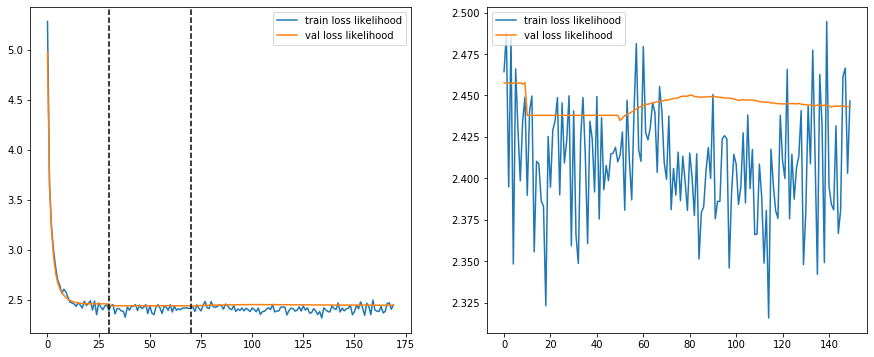

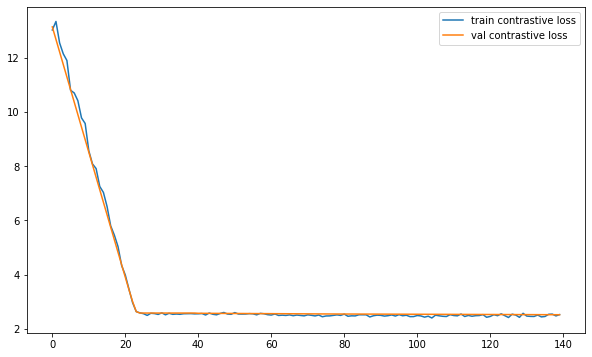

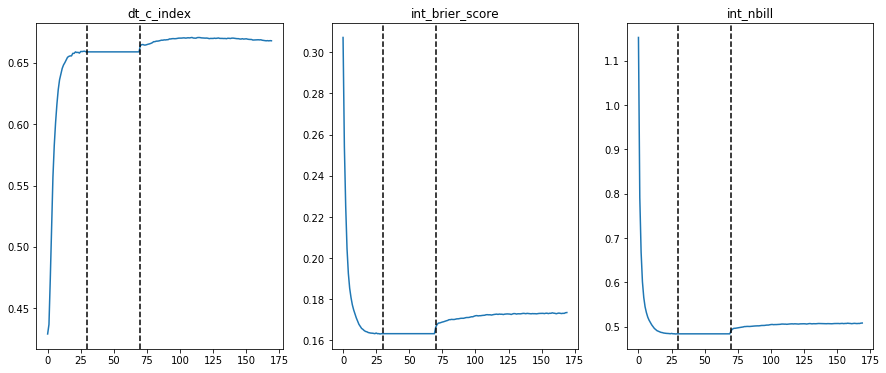

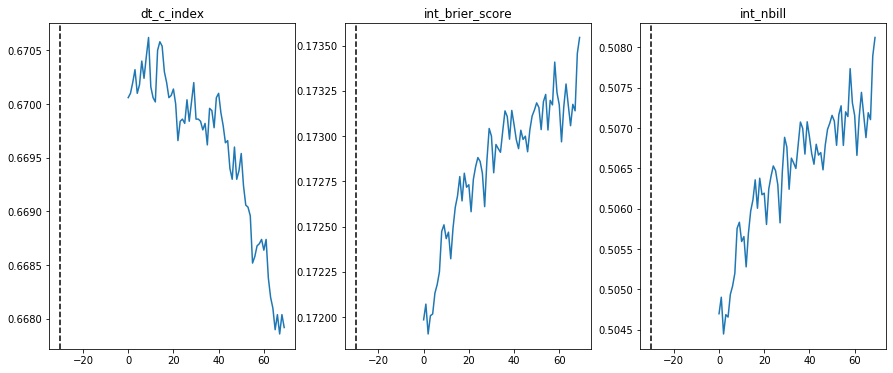


margin_weight:  0.1
contrastive_weight:  0.4


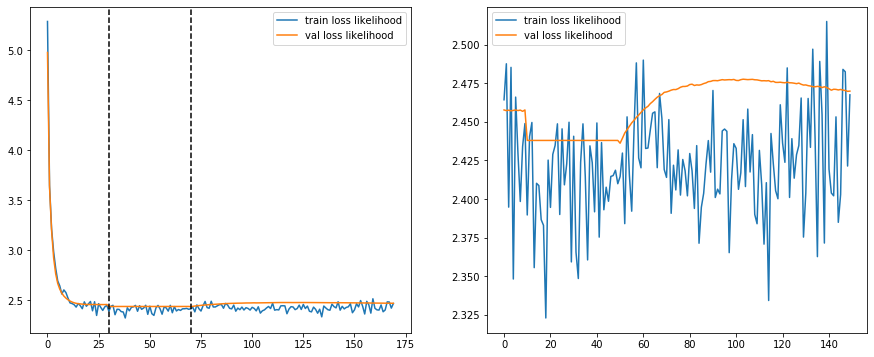

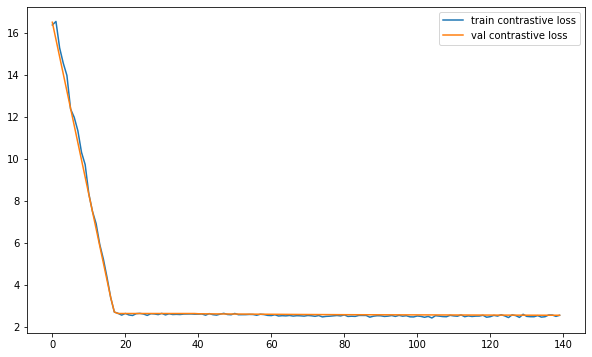

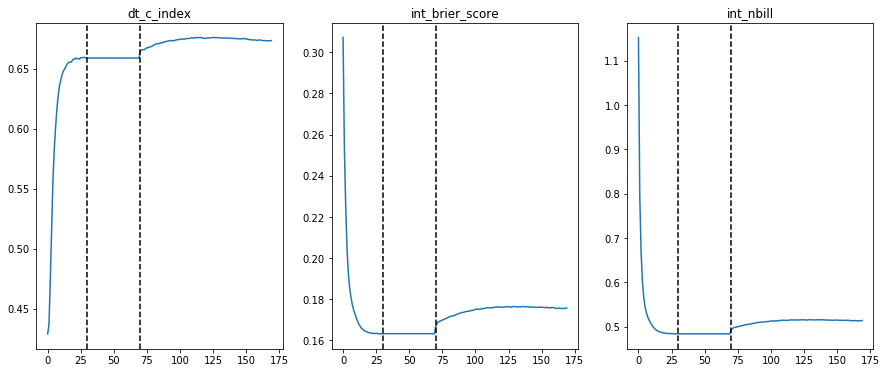

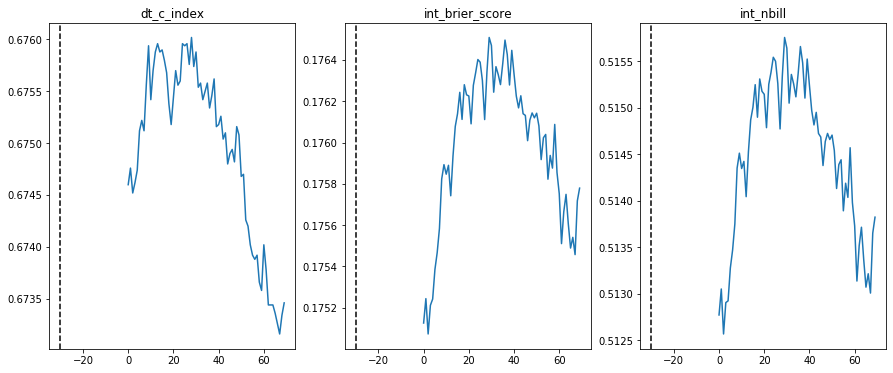


margin_weight:  0.1
contrastive_weight:  0.6


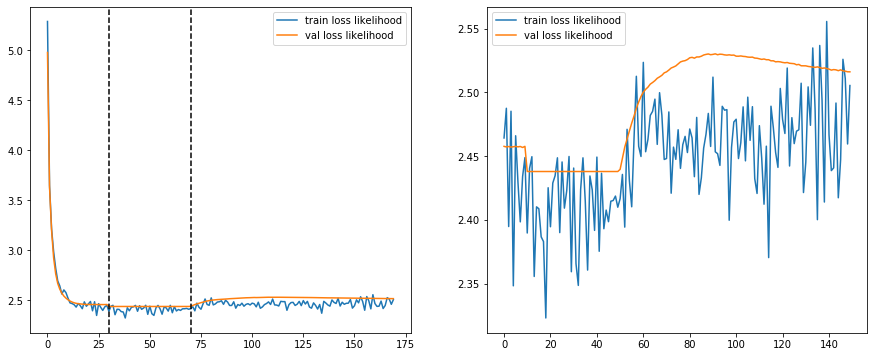

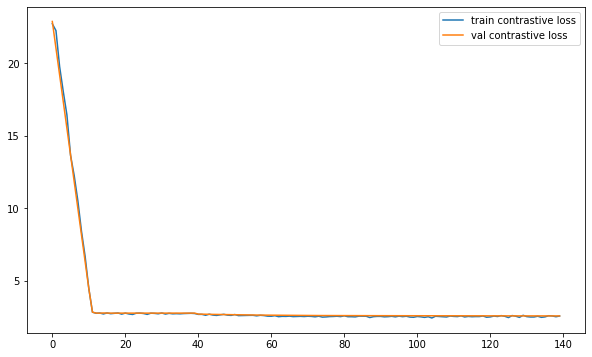

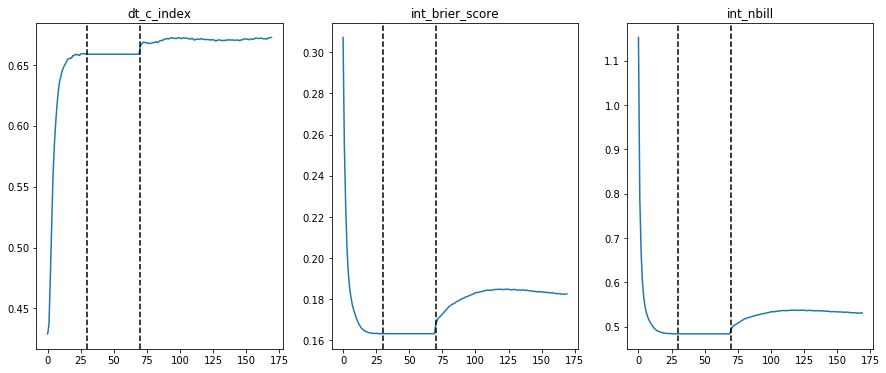

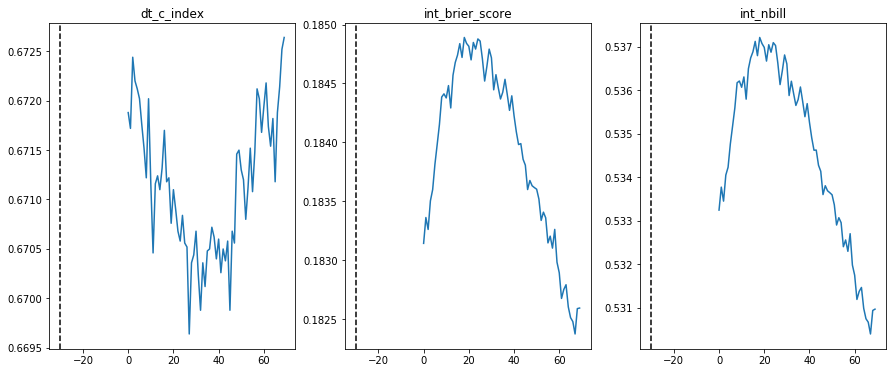


margin_weight:  0.1
contrastive_weight:  0.7


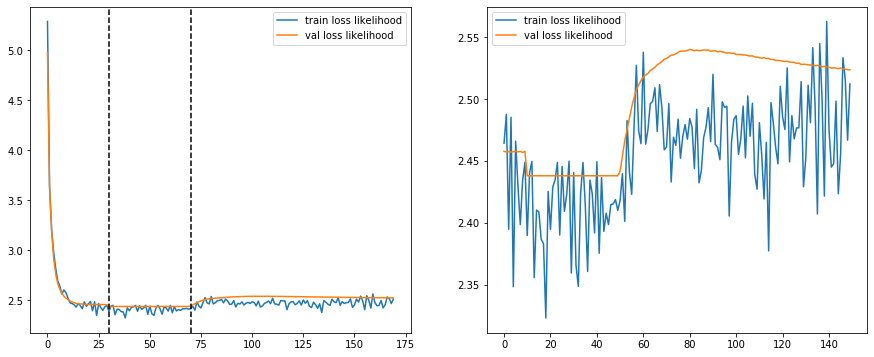

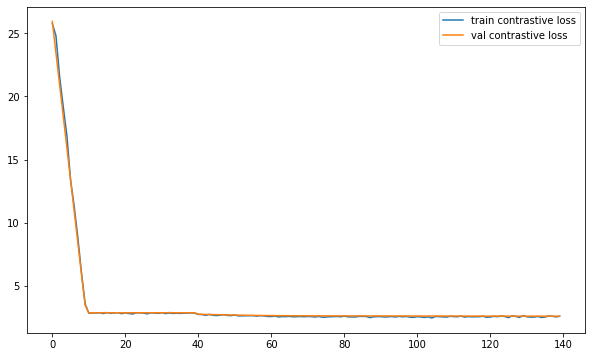

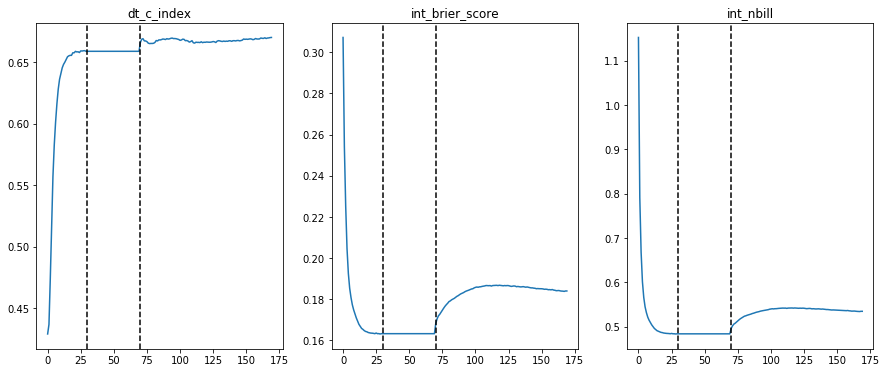

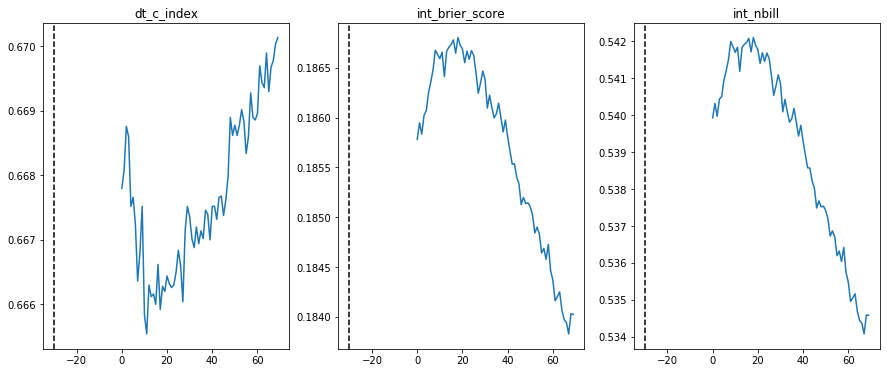


margin_weight:  0.1
contrastive_weight:  0.3


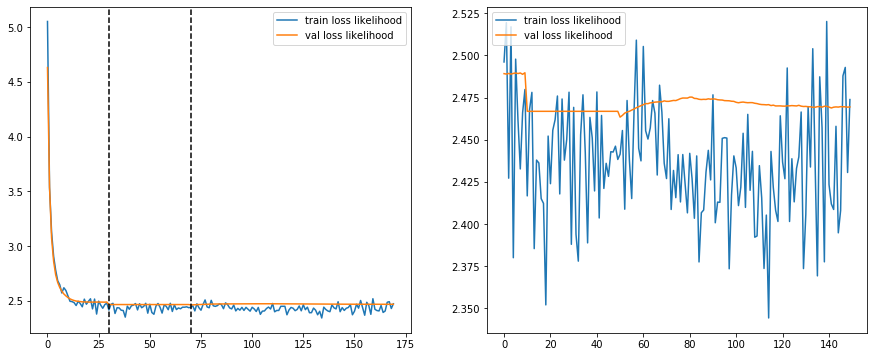

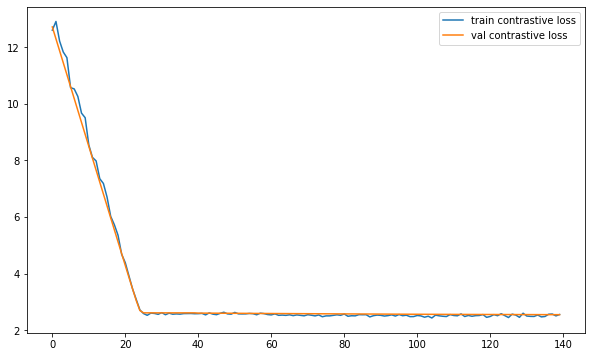

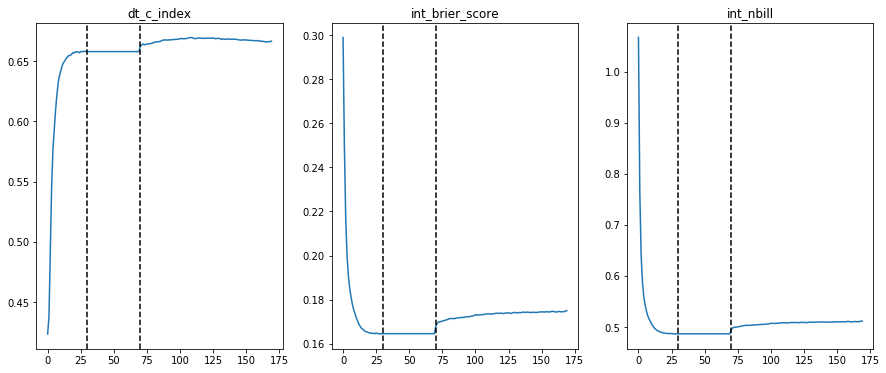

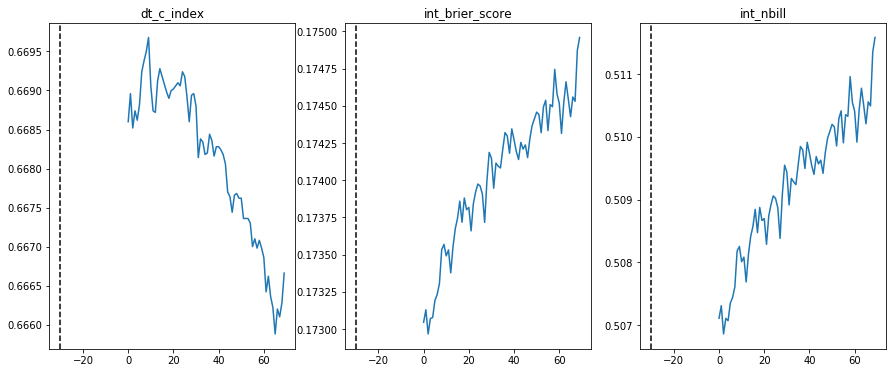


margin_weight:  0.1
contrastive_weight:  0.4


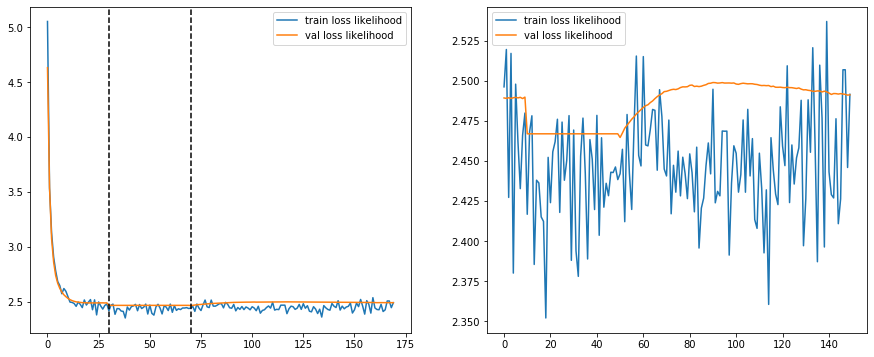

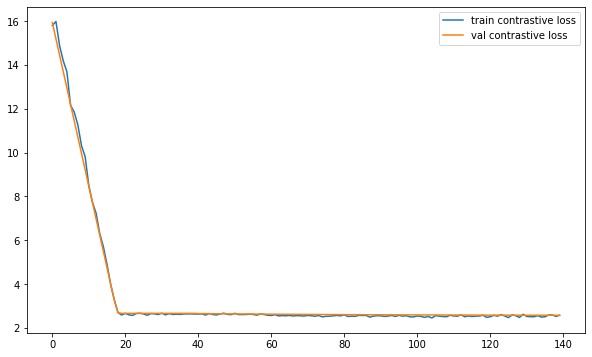

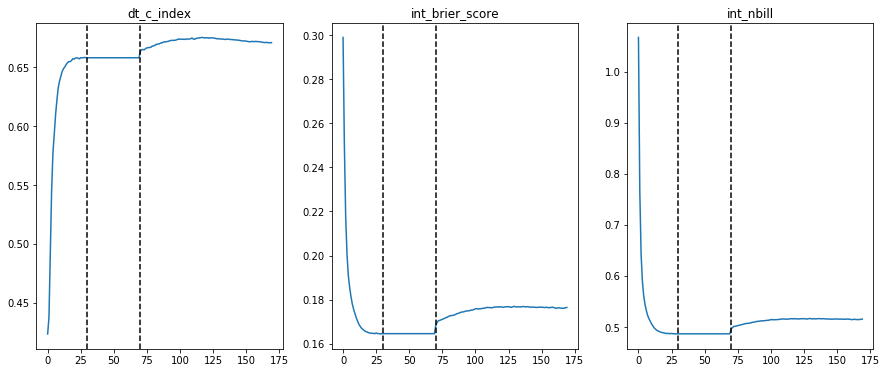

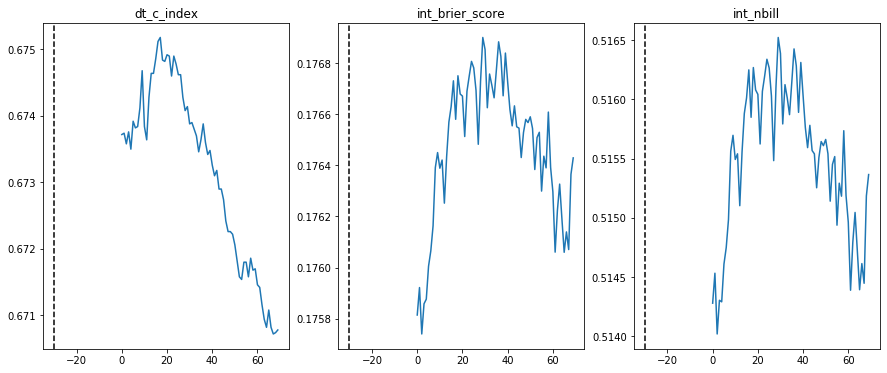


margin_weight:  0.1
contrastive_weight:  0.6


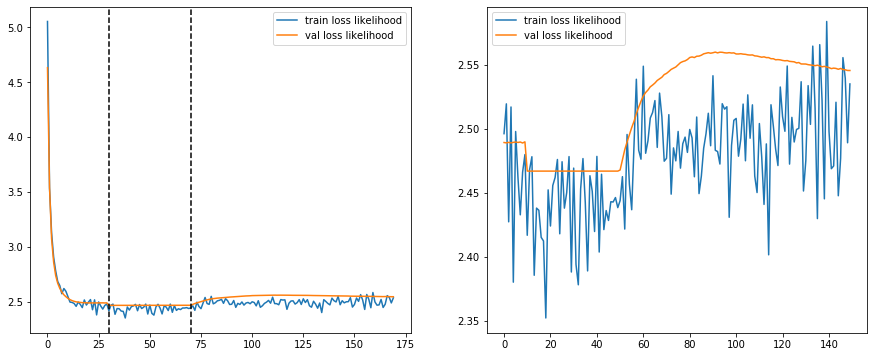

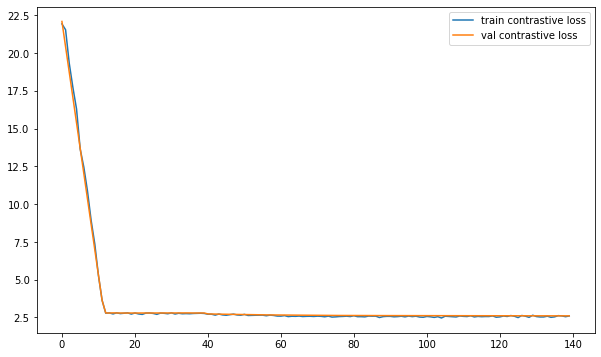

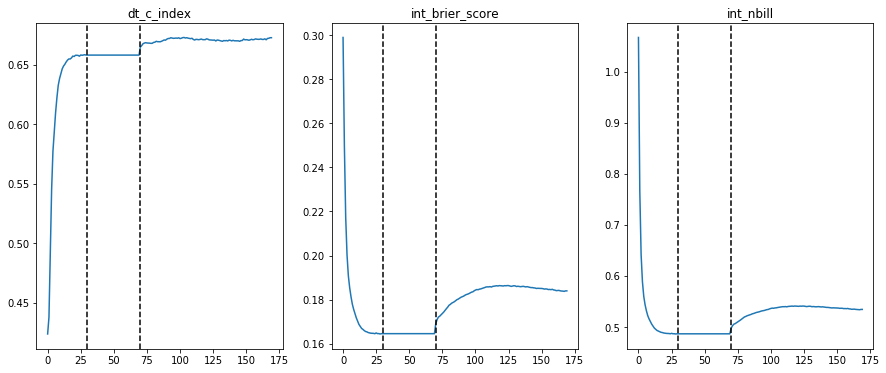

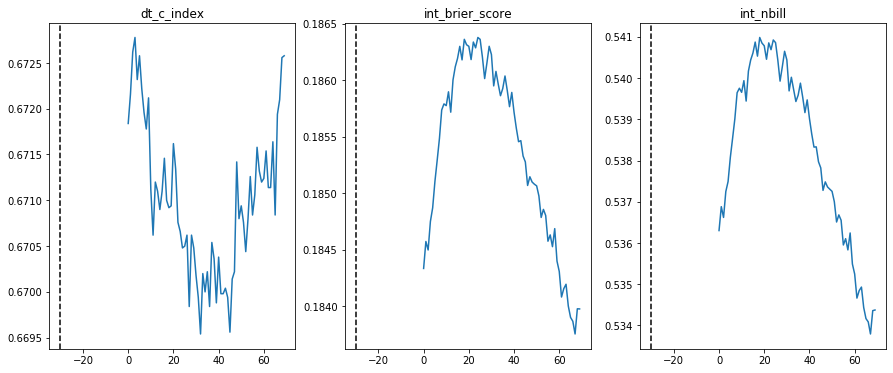


margin_weight:  0.1
contrastive_weight:  0.7


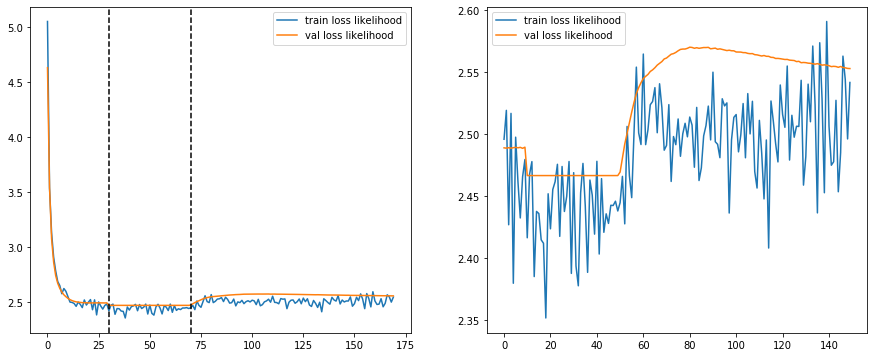

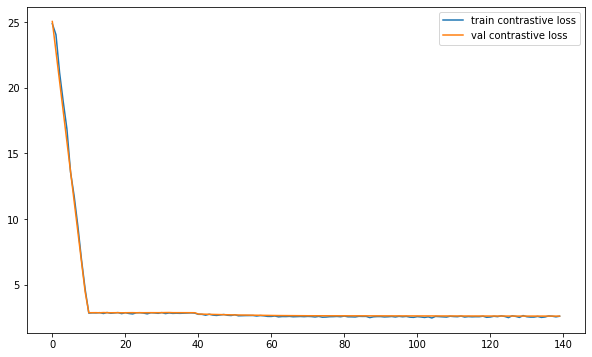

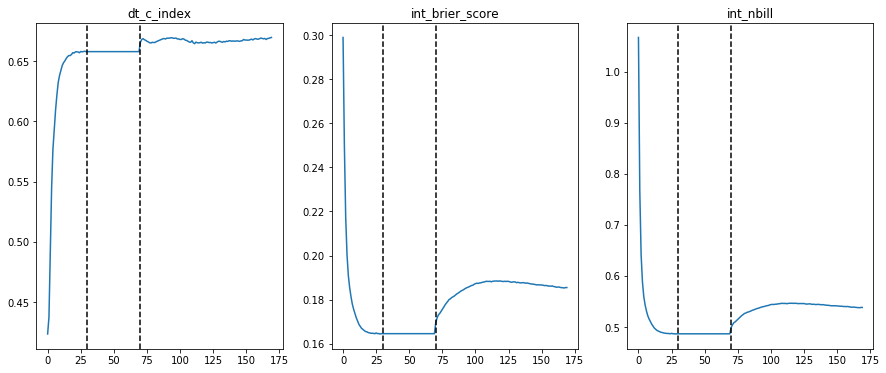

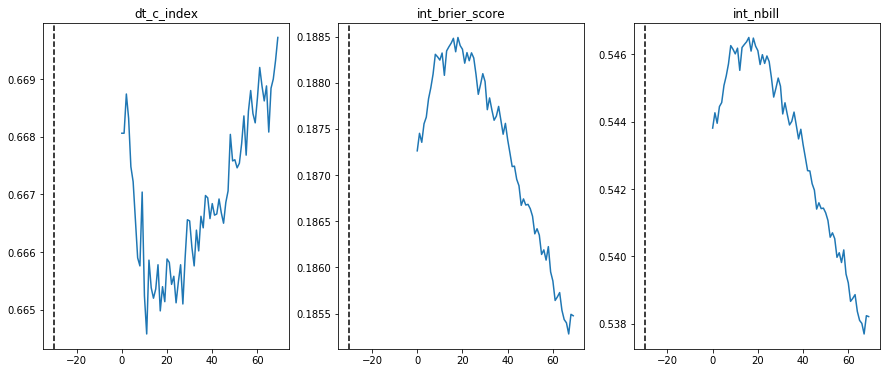

In [125]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
all_res = []
Output = namedtuple('Output', 'margin_weight contrastive_weight train_loss val_loss train_contr_loss val_contr_loss df_all_q all_pred all_lr')
for params in tqdm(grid):
    tf.reset_default_graph()
    params.update(static_params)
    all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)
    val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]
    all_q = []
    for pred in all_pred:
        all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
    df_all_q = pd.concat(all_q)
    
    res = Output(params['margin_weight'], params['contrastive_weight'], train_loss, val_loss, train_contr_loss, val_contr_loss, df_all_q, all_pred, all_lr)
    all_res.append(res)
    print("margin_weight: ", params['margin_weight'])
    print("contrastive_weight: ", params['contrastive_weight'])
    plot_results()

In [126]:
# with open('../output/combined_contr_1.pkl', 'wb') as f:
#     pickle.dump(all_res, f)

In [135]:
all_alphas = [params['alpha_reg'] for params in grid]

In [138]:
# with open('../output/combined_contr_1_0.pkl', 'wb') as f:
#     pickle.dump(all_res_alpha, f)

In [162]:
results_stats = []
for alpha, rest in zip(all_alphas, all_res):
    print(alpha)
    df_all_q = rest.df_all_q
    df_all_q['margin_weight'] = rest.margin_weight
    df_all_q['contrastive_weight'] = rest.contrastive_weight
    df_all_q['alpha_reg'] = alpha
    df_all_q['iteration'] = pd.Index(np.arange(0, df_all_q.shape[0]))    
    results_stats.append(df_all_q)

1e-06
1e-06
1e-06
1e-06
0.0001
0.0001
0.0001
0.0001


In [165]:
with open('../output/combined_contr.pkl', 'rb') as f:
    all_res_alpha_old = pickle.load(f)

In [167]:
for rest in all_res_alpha_old:
    df_all_q = rest.df_all_q
    df_all_q['margin_weight'] = rest.margin_weight
    df_all_q['contrastive_weight'] = rest.contrastive_weight
    df_all_q['alpha_reg'] = 1e-06
    df_all_q['iteration'] = pd.Index(np.arange(0, df_all_q.shape[0]))    
    results_stats.append(df_all_q)

In [168]:
q = pd.concat(results_stats)

In [169]:
q.shape

(2210, 8)

In [171]:
q.sample(5)

harell_c_index  dt_c_index  int_brier_score  int_nbill  margin_weight  \
0        0.648624    0.675558         0.176277   0.515252            0.1   
0        0.658422    0.658882         0.163279   0.483753            0.1   
0        0.658382    0.669759         0.172931   0.506568            0.1   
0        0.658022    0.670299         0.172776   0.506359            0.1   
0        0.456650    0.429037         0.307212   1.152355            0.1   

   contrastive_weight  alpha_reg  iteration  
0                 0.4   0.000001        122  
0                 1.0   0.000001         54  
0                 0.3   0.000001        133  
0                 0.3   0.000001        116  
0                 0.3   0.000001          0

In [172]:
q['margin_weight'].unique()

array([0.1])

In [173]:
q['contrastive_weight'].unique()

array([0.3, 0.4, 0.6, 0.7, 0.1, 0.5, 1. , 2. , 5. ])

In [174]:
q['alpha_reg'].unique()

array([1.e-06, 1.e-04])

In [176]:
a1 = q[q['alpha_reg'] == 1.e-06]

In [177]:
a1['contrastive_weight'].unique()

array([0.3, 0.4, 0.6, 0.7, 0.1, 0.5, 1. , 2. , 5. ])

In [182]:
import seaborn as sns

In [203]:
a1_melted = pd.melt(a1, id_vars=['margin_weight','contrastive_weight','alpha_reg','iteration'])

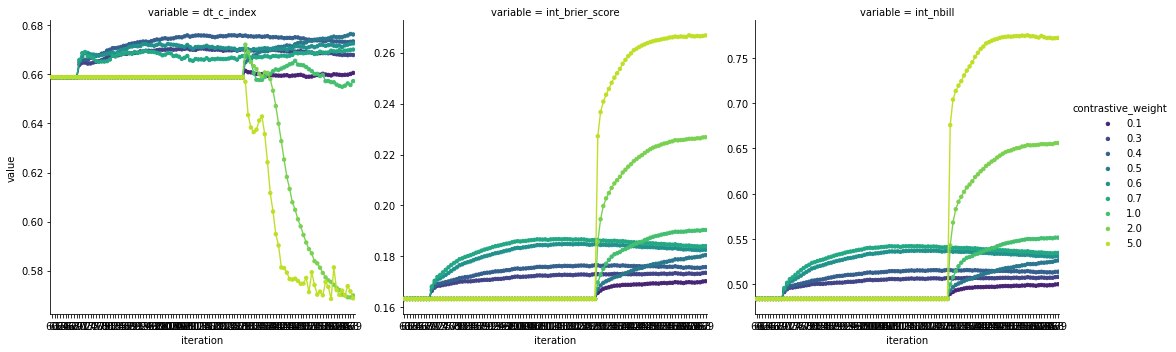

In [215]:
sns.catplot(data=a1_melted[(a1_melted['iteration'] >= 60) & (a1_melted['variable'] != 'harell_c_index')], 
            x='iteration', y='value', hue='contrastive_weight', kind='point', col='variable', sharey=False, markers='o', scale = 0.5, palette='viridis');

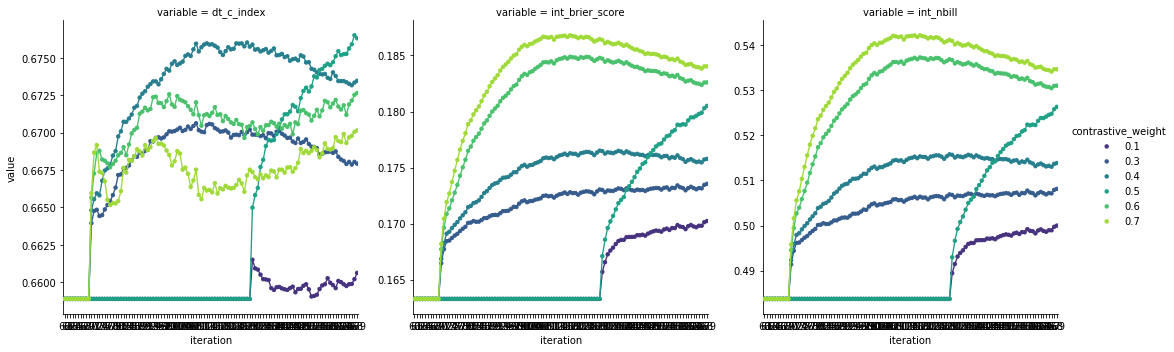

In [216]:
sns.catplot(data=a1_melted[(a1_melted['iteration'] >= 60) & (a1_melted['variable'] != 'harell_c_index') & (a1_melted['contrastive_weight'] < 1)], 
            x='iteration', y='value', hue='contrastive_weight', kind='point', col='variable', sharey=False, markers='o', scale = 0.5, palette='viridis');

In [220]:
a1_melted = pd.melt(q[q['contrastive_weight'] < 1], id_vars=['margin_weight','contrastive_weight','alpha_reg','iteration'])

In [223]:
a1_melted['alpha_reg'] = a1_melted['alpha_reg'].astype(str)
a1_melted['contrastive_weight'] = a1_melted['contrastive_weight'].astype(str)

In [236]:
a1_melted['alpha_reg'].unique()

array(['1e-06', '0.0001'], dtype=object)

In [240]:
a1_melted['contrastive_weight'].unique()

array(['0.3', '0.4', '0.6', '0.7', '0.1', '0.5'], dtype=object)

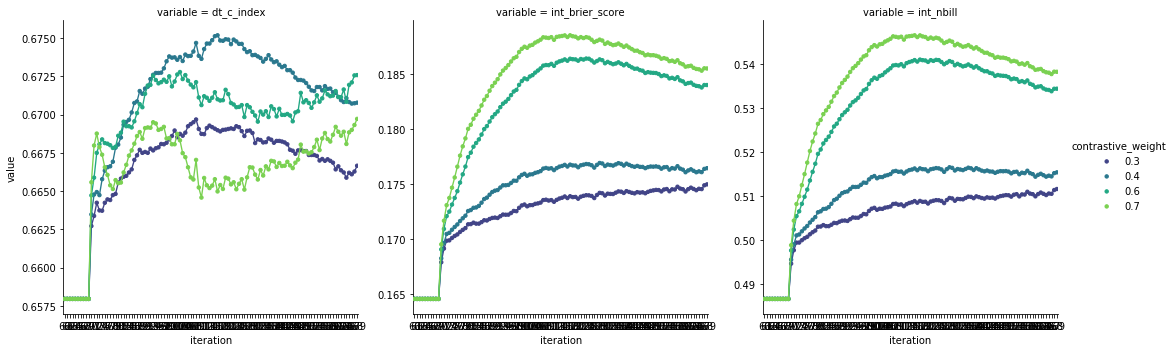

In [239]:
sns.catplot(data=a1_melted[(a1_melted['iteration'] >= 60) & (a1_melted['variable'] != 'harell_c_index') & (a1_melted['alpha_reg'] == '0.0001')], 
            x='iteration', y='value', hue='contrastive_weight', kind='point', col='variable', sharey=False, markers='o', scale = 0.5, palette='viridis');

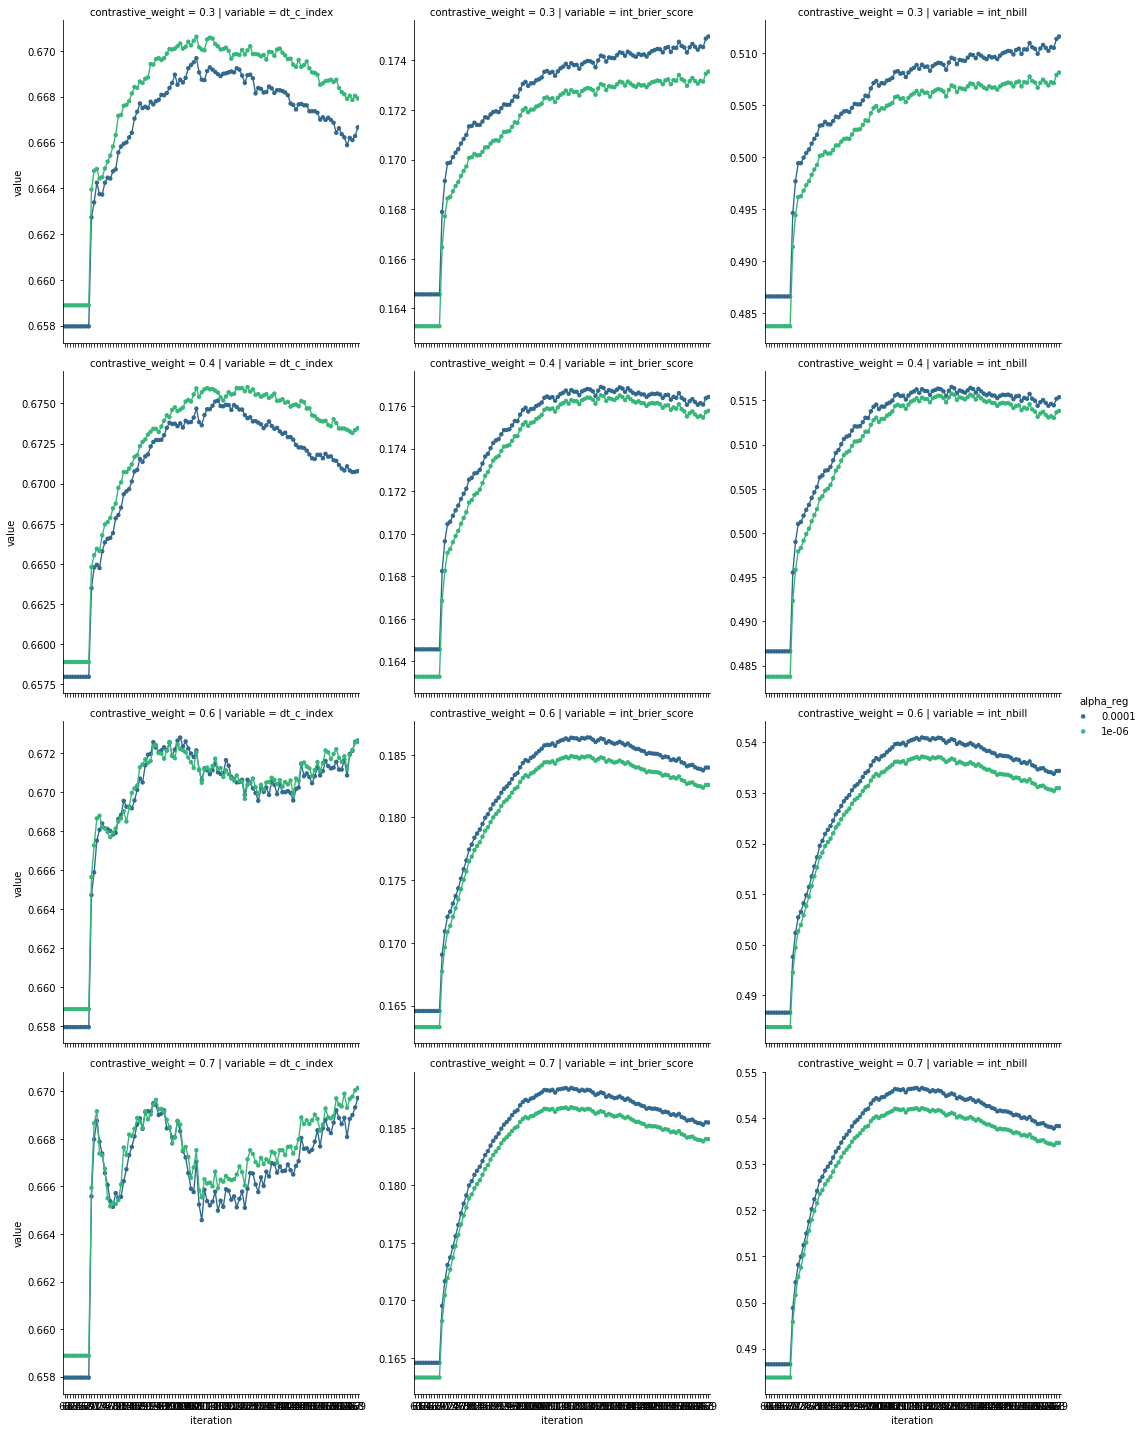

In [241]:
sns.catplot(data=a1_melted[(a1_melted['iteration'] >= 60) & (a1_melted['variable'] != 'harell_c_index') & 
                           (a1_melted['contrastive_weight'].isin(['0.3', '0.4', '0.6', '0.7']))], 
            x='iteration', y='value', row='contrastive_weight', hue='alpha_reg', kind='point', col='variable', 
            sharey=False, markers='o', scale = 0.5, palette='viridis');

In [ ]:
# попробуем learning rate decay

In [278]:
def test_hp(train_data, test_data, model_params):
    tf.reset_default_graph()
    model = ContrastiveRankingModel(input_shape=model_params['inp_shape'], seed=model_params['seed'], alpha_reg=model_params['alpha_reg'], 
                                    main_network=metabric_main_network, 
                                    contrastive_weight=model_params['contrastive_weight'], margin_weight=model_params['margin_weight'])
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    ## contrastive data generator
    # validation data
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size_contr'], 
                                  n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg = ContrastiveDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val_contrastive, x_batch_right_val_contrastive], y_batch_val_contrastive, sample_weight_val_contrastive, target_val_contrastive = next(
        dg.get_batch())
    val_size_contrastive = x_batch_left_val_contrastive.shape[0]
    # training data
    dg_contrastive = ContrastiveDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size_contr'],
                             n_time_bins=model_params['n_time_bins'])    
    n_batches_contrastive = min(dg_contrastive.ij_pos_sorted.shape[1], dg_contrastive.ij_neg_sorted.shape[1]) // model_params['batch_size_contr']
    
    
    n_epochs_contrastive = model_params['n_epochs_contrastive']
    n_epochs_contrastive_freezed = model_params['n_epochs_contrastive_freezed']
    
    ## binary data generator    
    # validation data
    dg = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg_binary = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val_binary, x_batch_right_val_binary], y_batch_val_binary, sample_weight_val_binary, target_val_binary = next(dg.get_batch())
    val_size_binary = x_batch_left_val_binary.shape[0]
    # training data
    dg_binary = BinaryDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])
    n_batches_binary = min(dg_binary.ij_pos_sorted.shape[1], dg_binary.ij_neg_sorted.shape[1]) // model_params['batch_size']
    n_epochs_binary = model_params['n_epochs_binary']
    
    # optimizators
    # cycling learning rate
    all_lr = []
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = cyclic_learning_rate(global_step=global_step, learning_rate=model_params['max_lr'] / 5, max_lr=model_params['max_lr'], 
                                         step_size=model_params['step_size'], mode='triangular2')

    
    all_pred = []
    train_loss = []
    val_loss = []
    train_contr_loss = []
    val_contr_loss = []
    # Launch the graph
#     with tf.device('/GPU:0'):
    with tf.Session() as sess:
        tf.set_random_seed(model_params['seed'])

        optimizer1 = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        train_op_weibull = optimizer1.minimize(model.main_loss, global_step=global_step, var_list=trainable_binary)
        optimizer3 = tf.train.GradientDescentOptimizer(learning_rate=model_params['learning_rate_contr_freezed'])
        train_op_contrastive_freezed = optimizer3.minimize(model.loss, var_list=trainable_contr)  
        # decaying learning rate
        decay_steps_m = int(n_batches_binary * 40)
        global_step_m = tf.Variable(0, trainable=False)
        decayed_learning_rate = tf.train.exponential_decay(model_params['learning_rate_contr'], 
                                                             global_step_m, 
                                                             decay_steps_m, 
                                                             0.1,
                                                             staircase=True)

        optimizer2 = tf.train.MomentumOptimizer(learning_rate=decayed_learning_rate, momentum=model_params['momentum'])
        train_op_contrastive = optimizer2.minimize(model.loss, var_list=trainable_contr_binary, global_step=global_step_m)

        init = tf.initialize_all_variables()
        sess.run(init)

        ## train standard weibull loss on binary batch generator
        for i in tqdm(range(n_epochs_binary)):
            # initialize generator
            gen = dg_binary.get_batch()
            # for each batch
            for j in range(n_batches_binary):
                # get batch data
                [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                feed_dict = {
                    model.x_a: x_batch_left, 
                    model.x_b: x_batch_right, 
                    model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                    model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                    model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                    model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                    model.target: target.reshape((model_params['batch_size'], 1)),
                    model.sample_weight: sample_weight
                }

                # train model
                _, l = sess.run([train_op_weibull, model.main_loss], feed_dict=feed_dict)

             # change learning rate
            assign_op = global_step.assign(i)
            sess.run(assign_op)               
            new_lr = sess.run(optimizer1._learning_rate_tensor)
            all_lr.append(new_lr)

            # get predictions for validation data
            pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
            all_pred.append(pred)
            # save train loss
            train_loss.append(l)
            # save test loss
            l = sess.run([model.main_loss], feed_dict={
                model.x_a: x_batch_left_val_binary, 
                model.x_b: x_batch_right_val_binary, 
                model.t_a: y_batch_val_binary[:, 0].reshape((val_size_binary, 1)),
                model.t_b: y_batch_val_binary[:, 1].reshape((val_size_binary, 1)),
                model.y_a: y_batch_val_binary[:, 2].reshape((val_size_binary, 1)),
                model.y_b: y_batch_val_binary[:, 3].reshape((val_size_binary, 1)),
                model.target: target_val_binary.reshape((val_size_binary, 1)),
                model.sample_weight: sample_weight_val_binary
            }) 
            val_loss.append(l)


        ## train contrastive loss on contrastive batch generator FREEZED
        for i in tqdm(range(n_epochs_contrastive_freezed)):
            # initialize generator
            gen = dg_contrastive.get_batch()
            # for each batch
            for j in range(n_batches_contrastive):
                # get batch data
                [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                feed_dict = {
                    model.x_a: x_batch_left, 
                    model.x_b: x_batch_right, 
                    model.t_a: y_batch[:, 0].reshape((model_params['batch_size_contr'], 1)),
                    model.t_b: y_batch[:, 1].reshape((model_params['batch_size_contr'], 1)),
                    model.y_a: y_batch[:, 2].reshape((model_params['batch_size_contr'], 1)),
                    model.y_b: y_batch[:, 3].reshape((model_params['batch_size_contr'], 1)),
                    model.target: target.reshape((model_params['batch_size_contr'], 1)),
                    model.sample_weight: sample_weight
                }

                # train model
                _, l, l_c = sess.run([train_op_contrastive_freezed, model.main_loss, model.loss], feed_dict=feed_dict)

            # get predictions for validation data
            pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
            all_pred.append(pred)
            # save train loss
            train_loss.append(l)
            train_contr_loss.append(l_c)
            # save test loss
            l, l_c = sess.run([model.main_loss, model.loss], feed_dict={
                model.x_a: x_batch_left_val_contrastive, 
                model.x_b: x_batch_right_val_contrastive, 
                model.t_a: y_batch_val_contrastive[:, 0].reshape((val_size_contrastive, 1)),
                model.t_b: y_batch_val_contrastive[:, 1].reshape((val_size_contrastive, 1)),
                model.y_a: y_batch_val_contrastive[:, 2].reshape((val_size_contrastive, 1)),
                model.y_b: y_batch_val_contrastive[:, 3].reshape((val_size_contrastive, 1)),
                model.target: target_val_contrastive.reshape((val_size_contrastive, 1)),
                model.sample_weight: sample_weight_val_contrastive
            }) 
            val_loss.append(l)     
            val_contr_loss.append(l_c)




        ## train contrastive loss on contrastive batch generator
        for i in tqdm(range(n_epochs_contrastive)):
            # initialize generator
            gen = dg_contrastive.get_batch()
            # for each batch
            for j in range(n_batches_contrastive):
                # get batch data
                [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                feed_dict = {
                    model.x_a: x_batch_left, 
                    model.x_b: x_batch_right, 
                    model.t_a: y_batch[:, 0].reshape((model_params['batch_size_contr'], 1)),
                    model.t_b: y_batch[:, 1].reshape((model_params['batch_size_contr'], 1)),
                    model.y_a: y_batch[:, 2].reshape((model_params['batch_size_contr'], 1)),
                    model.y_b: y_batch[:, 3].reshape((model_params['batch_size_contr'], 1)),
                    model.target: target.reshape((model_params['batch_size_contr'], 1)),
                    model.sample_weight: sample_weight
                }

                # train model
                _, l, l_c = sess.run([train_op_contrastive, model.main_loss, model.loss], feed_dict=feed_dict)

            # get predictions for validation data
            pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
            all_pred.append(pred)
            # save train loss
            train_loss.append(l)
            train_contr_loss.append(l_c)
            # save test loss
            l, l_c = sess.run([model.main_loss, model.loss], feed_dict={
                model.x_a: x_batch_left_val_contrastive, 
                model.x_b: x_batch_right_val_contrastive, 
                model.t_a: y_batch_val_contrastive[:, 0].reshape((val_size_contrastive, 1)),
                model.t_b: y_batch_val_contrastive[:, 1].reshape((val_size_contrastive, 1)),
                model.y_a: y_batch_val_contrastive[:, 2].reshape((val_size_contrastive, 1)),
                model.y_b: y_batch_val_contrastive[:, 3].reshape((val_size_contrastive, 1)),
                model.target: target_val_contrastive.reshape((val_size_contrastive, 1)),
                model.sample_weight: sample_weight_val_contrastive
            }) 
            val_loss.append(l)     
            val_contr_loss.append(l_c)

    return all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr


In [279]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive_freezed = 40
n_epochs_contrastive = 100

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive_freezed': n_epochs_contrastive_freezed,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr_freezed': 0.0001,
    'learning_rate_contr': 0.00005,
    'momentum': 0.7
}


In [280]:
batch_size = [1024]
alpha_reg = [1e-6]
batch_size_contr = [1024]
margin_weight = [1e-1]

param_grid = {
    'batch_size': batch_size, 
    'batch_size_contr': batch_size_contr,
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': [0.4]
}
grid = ParameterGrid(param_grid)


margin_weight:  0.1
contrastive_weight:  0.4


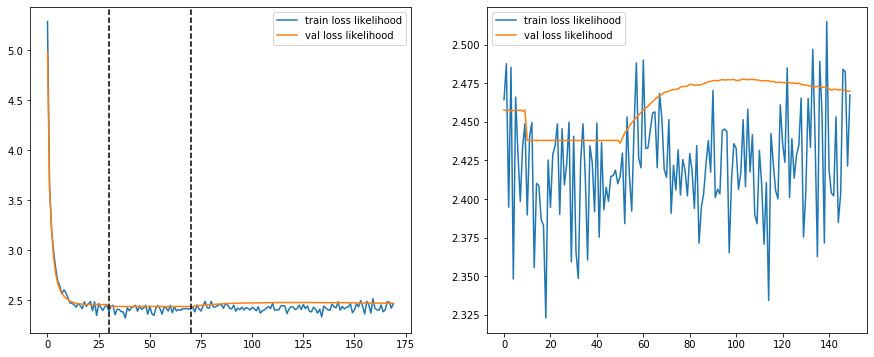

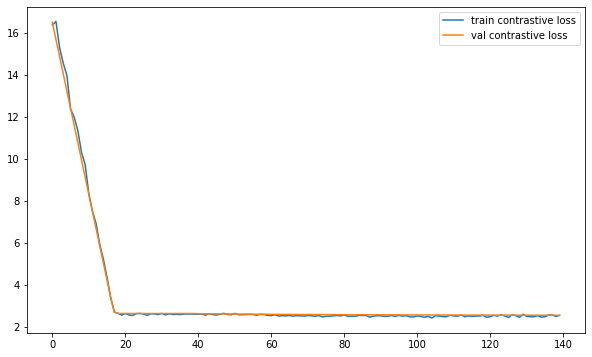

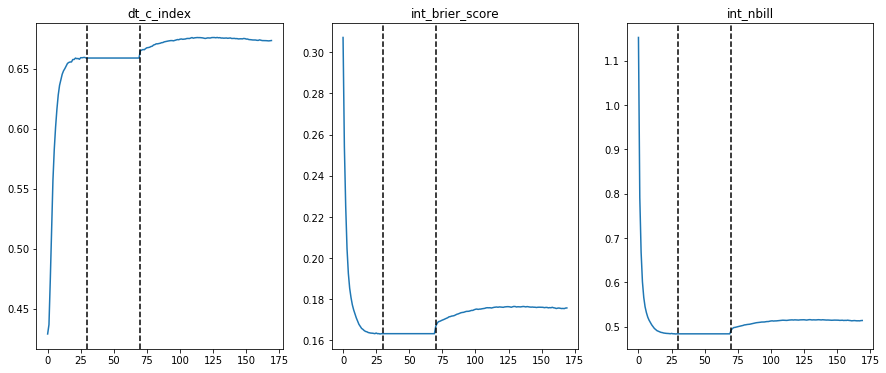

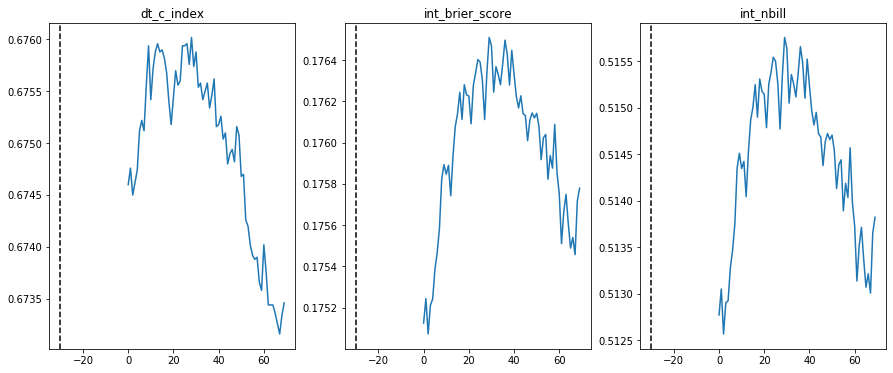

In [281]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
all_res = []
Output = namedtuple('Output', 'margin_weight contrastive_weight alpha_reg train_loss val_loss train_contr_loss val_contr_loss df_all_q all_pred all_lr')
for params in tqdm(grid):
    tf.reset_default_graph()
    params.update(static_params)
    all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)
    val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]
    all_q = []
    for pred in all_pred:
        all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
    df_all_q = pd.concat(all_q)
    
    res = Output(params['margin_weight'], params['contrastive_weight'], params['alpha_reg'], 
                 train_loss, val_loss, train_contr_loss, val_contr_loss, df_all_q, all_pred, all_lr)
    all_res.append(res)
    print("margin_weight: ", params['margin_weight'])
    print("contrastive_weight: ", params['contrastive_weight'])
    plot_results()

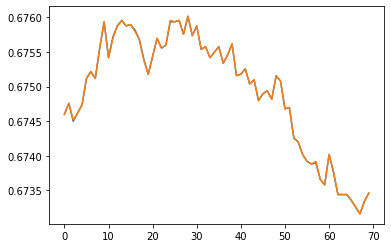

In [282]:
plt.plot(df_all_q['dt_c_index'].values[100:], label='decayed')
plt.plot(a1_melted[(a1_melted['contrastive_weight'] == '0.4') & (a1_melted['variable'] == 'dt_c_index') & (a1_melted['alpha_reg'] == '1e-06')]['value'].values[100:], label='normal')

In [283]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive_freezed = 40
n_epochs_contrastive = 100

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive_freezed': n_epochs_contrastive_freezed,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr_freezed': 0.0001,
    'learning_rate_contr': 0.00005,
    'momentum': 0.7
}


In [284]:
batch_size = [1024]
alpha_reg = [1e-6]
batch_size_contr = [1024]
margin_weight = [1e-1]

param_grid = {
    'batch_size': batch_size, 
    'batch_size_contr': batch_size_contr,
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': [0.5]
}
grid = ParameterGrid(param_grid)


margin_weight:  0.1
contrastive_weight:  0.5


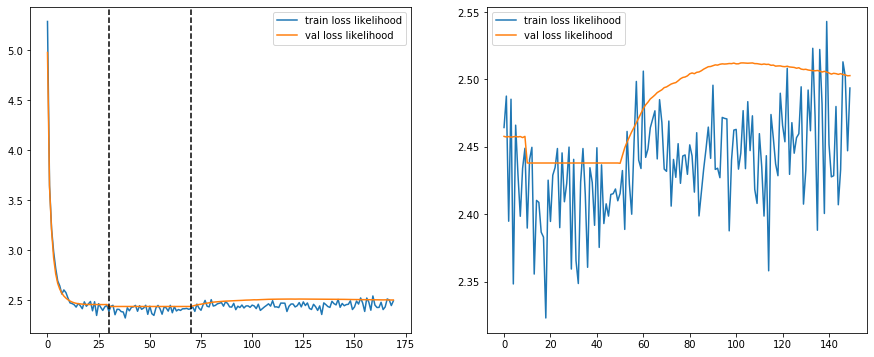

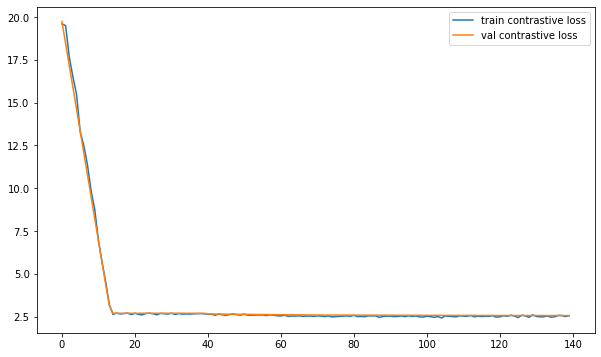

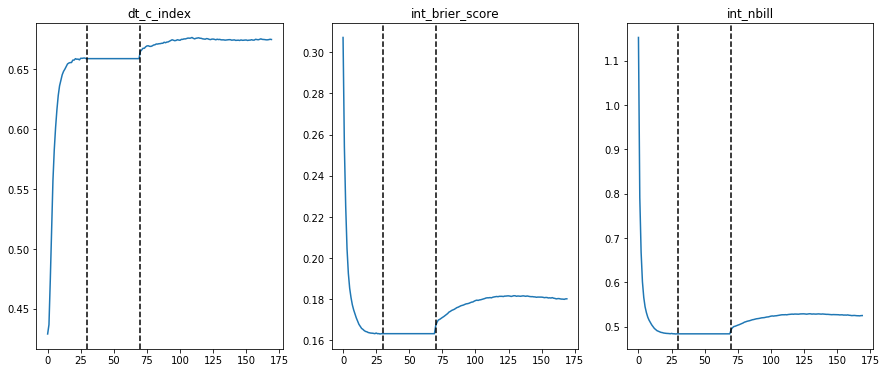

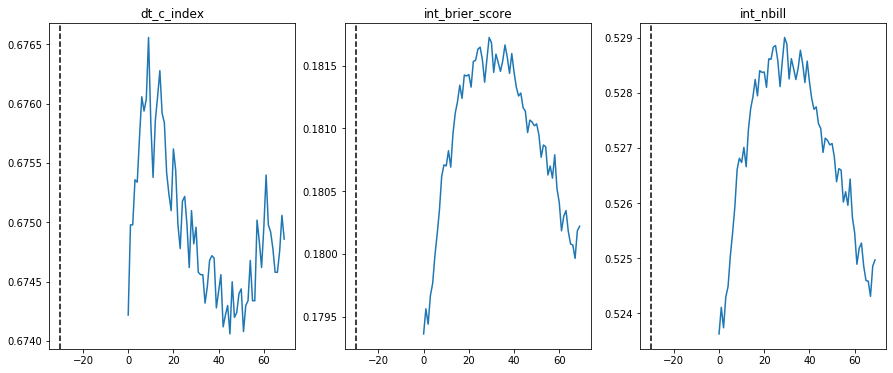

In [285]:
fold = 0
test_data = df_all['val']
train_data = df_all['cv'][fold]['train']
all_res = []
Output = namedtuple('Output', 'margin_weight contrastive_weight alpha_reg train_loss val_loss train_contr_loss val_contr_loss df_all_q all_pred all_lr')
for params in tqdm(grid):
    tf.reset_default_graph()
    params.update(static_params)
    all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)
    val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]
    all_q = []
    for pred in all_pred:
        all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
    df_all_q = pd.concat(all_q)
    
    res = Output(params['margin_weight'], params['contrastive_weight'], params['alpha_reg'], 
                 train_loss, val_loss, train_contr_loss, val_contr_loss, df_all_q, all_pred, all_lr)
    all_res.append(res)
    print("margin_weight: ", params['margin_weight'])
    print("contrastive_weight: ", params['contrastive_weight'])
    plot_results()

In [ ]:
n_epochs_freeze -> побольше
n_epochs_contr -> побольше
contrastive weight: best - 0.4, 0.5, 0.6. Есть точка перегиба в ,5 (до - качество растет, после начинает ухудшаться)
чем меньше contrastive weight тем меньше страдают int_nbill/int_brier_score
чем больше альфа, тем хуже все метрики

In [ ]:
прогон по всем фолдам
0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 1
1e-6, 1e-4
n_epochs_freeze -> побольше
n_epochs_contr -> побольше
добавлять alpha значение к результатам

In [ ]:
что происходит с предсказаниями????? средние и доверительные интервалы, потом по фолдам - боксплоты
бутстрапом распределение средних

In [ ]:
почему int_nbill растет - добавить специальный лосс?

In [8]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs_binary = 30
n_epochs_contrastive_freezed = 60
n_epochs_contrastive = 120

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs_binary': n_epochs_binary,
    'n_epochs_contrastive_freezed': n_epochs_contrastive_freezed,
    'n_epochs_contrastive': n_epochs_contrastive,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'learning_rate_contr_freezed': 0.0001,
    'learning_rate_contr': 0.00005,
    'momentum': 0.7
}


In [9]:
batch_size = [1024]
alpha_reg = [1e-6, 1e-4]
batch_size_contr = [1024]
margin_weight = [1e-1]

param_grid = {
    'batch_size': batch_size, 
    'batch_size_contr': batch_size_contr,
    'alpha_reg': alpha_reg,
    'margin_weight': margin_weight,
    'contrastive_weight': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 1]
}
grid = ParameterGrid(param_grid)

In [11]:
from contrastive_model import train_model
from collections import namedtuple

In [12]:
Output = namedtuple('Output', 'fold margin_weight contrastive_weight alpha_reg train_loss val_loss train_contr_loss val_contr_loss df_all_q all_pred all_lr')
test_data = df_all['val']
all_res = []
for fold in tqdm(folds):
    train_data = df_all['cv'][fold]['train']
    for params in tqdm(grid):
        tf.reset_default_graph()
        params.update(static_params)
        all_pred, train_loss, val_loss, train_contr_loss, val_contr_loss, all_lr = train_model(train_data=train_data, test_data=test_data, model_params=params)
        val_loss = [l[0] if isinstance(l, list) else l for l in val_loss]
        all_q = []
        for pred in all_pred:
            all_q.append(test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103))
        df_all_q = pd.concat(all_q)
        res = Output(fold, params['margin_weight'], params['contrastive_weight'], params['alpha_reg'], 
                     train_loss, val_loss, train_contr_loss, val_contr_loss, df_all_q, all_pred, all_lr)
        all_res.append(res)
        
        with open('../output/combined_contrastive.pkl', 'wb') as f:
            pickle.dump(all_res, f)





Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dense instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [13]:
from collections import namedtuple
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("viridis")

Output = namedtuple('Output', 'fold margin_weight contrastive_weight alpha_reg train_loss val_loss train_contr_loss val_contr_loss df_all_q all_pred all_lr')

In [14]:
with open('../output/combined_contrastive.pkl', 'rb') as f:
    all_res = pickle.load(f)

In [57]:
def get_bp_mean(res, n_repeats=100):
    
    pred_last = res.all_pred[-1]
    all_means = np.zeros((n_repeats, 2))
    for i in range(n_repeats):
        ind_sample = np.random.choice(a=np.arange(pred_last.shape[0]), size=pred_last.shape[0], replace=True)
        all_means[i, :] = np.mean(pred_last[ind_sample, :], axis=0)
    return np.mean(all_means, axis=0)
    

In [89]:
all_q_data = []
for res in all_res:
    q_data = res.df_all_q
    q_data['fold'] = res.fold
    q_data['margin_weight'] = res.margin_weight
    q_data['contrastive_weight'] = res.contrastive_weight
    q_data['margin_weight'] = res.margin_weight
    q_data['alpha_reg'] = res.alpha_reg
    q_data['iteration'] = pd.Index(np.arange(0, q_data.shape[0])) 
    # val quality
    q_data['dt_c_index_end'] = q_data['dt_c_index'][-20:].mean()
    q_data['int_brier_score_end'] = q_data['int_brier_score'][-20:].mean()
    q_data['int_nbill_end'] = q_data['int_nbill'][-20:].mean()
    # weibull params
    params_means = get_bp_mean(res, 100)
    q_data['alpha_mean'] = params_means[0]
    q_data['beta_mean'] = params_means[1]
    params_std = np.std(res.all_pred[-1], axis=0)
    q_data['alpha_std'] = params_std[0]
    q_data['beta_std'] = params_std[1]
    # losses    
    q_data['val_loss'] = res.val_loss
    q_data['train_loss'] = res.train_loss
    q_data['val_contr_loss'] = [0] * 30 + val_contr_loss
    q_data['train_contr_loss'] = [0] * 30 + train_contr_loss
    all_q_data.append(q_data)

In [90]:
df_all_q_data = pd.concat(all_q_data)

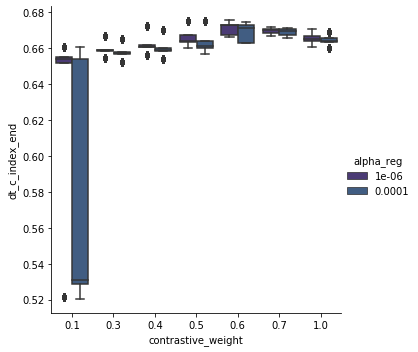

In [22]:
sns.catplot(data=df_all_q_data, x='contrastive_weight', y='dt_c_index_end', hue='alpha_reg', kind='box');

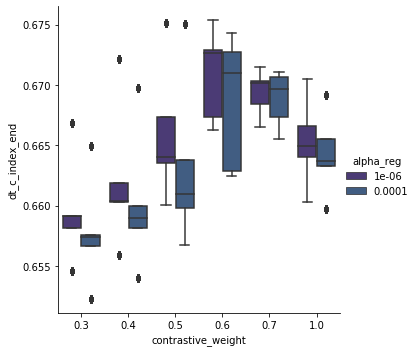

In [23]:
sns.catplot(data=df_all_q_data[df_all_q_data['contrastive_weight'] != 0.1], x='contrastive_weight', y='dt_c_index_end', hue='alpha_reg', kind='box');

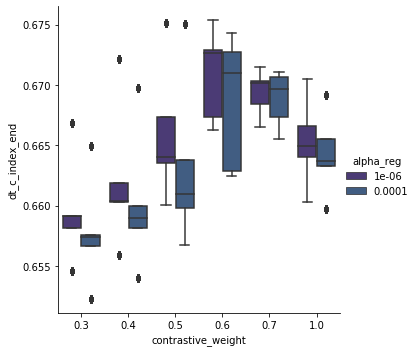

In [19]:
sns.catplot(data=df_all_q_data[df_all_q_data['contrastive_weight'] != 0.1], x='contrastive_weight', y='dt_c_index_end', hue='alpha_reg', kind='box');

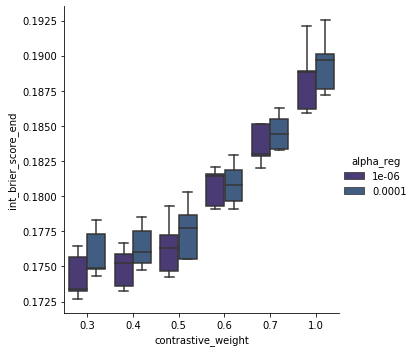

In [24]:
sns.catplot(data=df_all_q_data[df_all_q_data['contrastive_weight'] != 0.1], x='contrastive_weight', y='int_brier_score_end', hue='alpha_reg', kind='box');

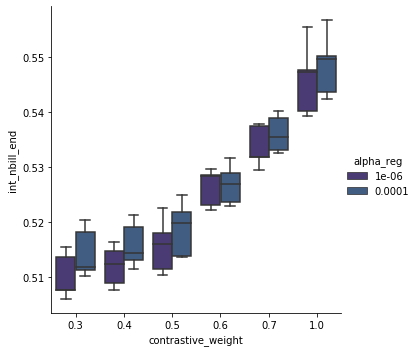

In [25]:
sns.catplot(data=df_all_q_data[df_all_q_data['contrastive_weight'] != 0.1], x='contrastive_weight', y='int_nbill_end', hue='alpha_reg', kind='box');

In [74]:
pred_means = df_all_q_data[['fold', 'contrastive_weight', 'alpha_reg', 'alpha_mean', 'beta_mean','alpha_std', 'beta_std']].drop_duplicates()

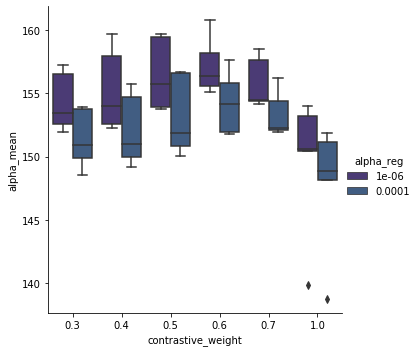

In [75]:
sns.catplot(data=pred_means[pred_means['contrastive_weight'] != 0.1], x='contrastive_weight', y='alpha_mean', hue='alpha_reg', kind='box');

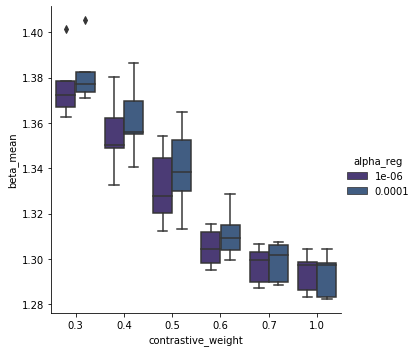

In [76]:
sns.catplot(data=pred_means[pred_means['contrastive_weight'] != 0.1], x='contrastive_weight', y='beta_mean', hue='alpha_reg', kind='box');

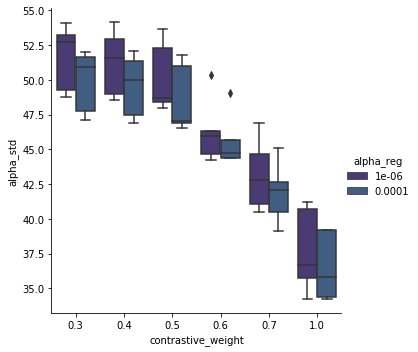

In [77]:
sns.catplot(data=pred_means[pred_means['contrastive_weight'] != 0.1], x='contrastive_weight', y='alpha_std', hue='alpha_reg', kind='box');

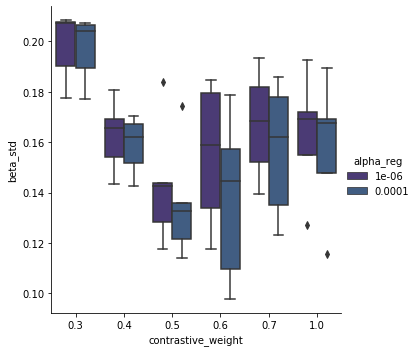

In [78]:
sns.catplot(data=pred_means[pred_means['contrastive_weight'] != 0.1], x='contrastive_weight', y='beta_std', hue='alpha_reg', kind='box');

Losses and quality metrics for fold 0 for different contrastive weights

In [91]:
df_all_q_data.head()

harell_c_index  dt_c_index  int_brier_score  int_nbill  fold  \
0        0.456650    0.429037         0.307212   1.152355     0   
0        0.477445    0.436775         0.254165   0.791518     0   
0        0.514676    0.474006         0.225155   0.667685     0   
0        0.562085    0.516616         0.204588   0.601197     0   
0        0.579081    0.556986         0.192586   0.565798     0   

   margin_weight  contrastive_weight  alpha_reg  iteration  dt_c_index_end  \
0            0.1                 0.1   0.000001          0         0.66051   
0            0.1                 0.1   0.000001          1         0.66051   
0            0.1                 0.1   0.000001          2         0.66051   
0            0.1                 0.1   0.000001          3         0.66051   
0            0.1                 0.1   0.000001          4         0.66051   

   int_brier_score_end  int_nbill_end  alpha_mean  beta_mean  alpha_std  \
0             0.172021        0.50394   156.25718   1.417479  53.347046   
0             0.172021        0.50394   156.25718   1.417479  53.347046   
0             0.172021        0.50394   156.25718   1.417479  53.347046   
0             0.172021        0.50394   156.25718   1.417479  53.347046   
0             0.172021        0.50394   156.25718   1.417479  53.347046   

   beta_std  val_loss  train_loss  val_contr_loss  train_contr_loss  
0   0.31601  4.974442    5.284485             0.0               0.0  
0   0.31601  3.629181    3.647465             0.0               0.0  
0   0.31601  3.196431    3.213192             0.0               0.0  
0   0.31601  2.923065    2.985117             0.0               0.0  
0   0.31601  2.763882    2.820347             0.0               0.0

In [96]:
fold_0_data = df_all_q_data[(df_all_q_data['fold'] == 0)]

In [98]:
melted_data = pd.melt(fold_0_data, id_vars=['contrastive_weight', 'alpha_reg', 'iteration'], value_vars=['dt_c_index', 'int_brier_score', 'int_nbill', 
                                                                                                         'val_loss', 'train_loss', 
                                                                                                         'val_contr_loss', 'train_contr_loss'])

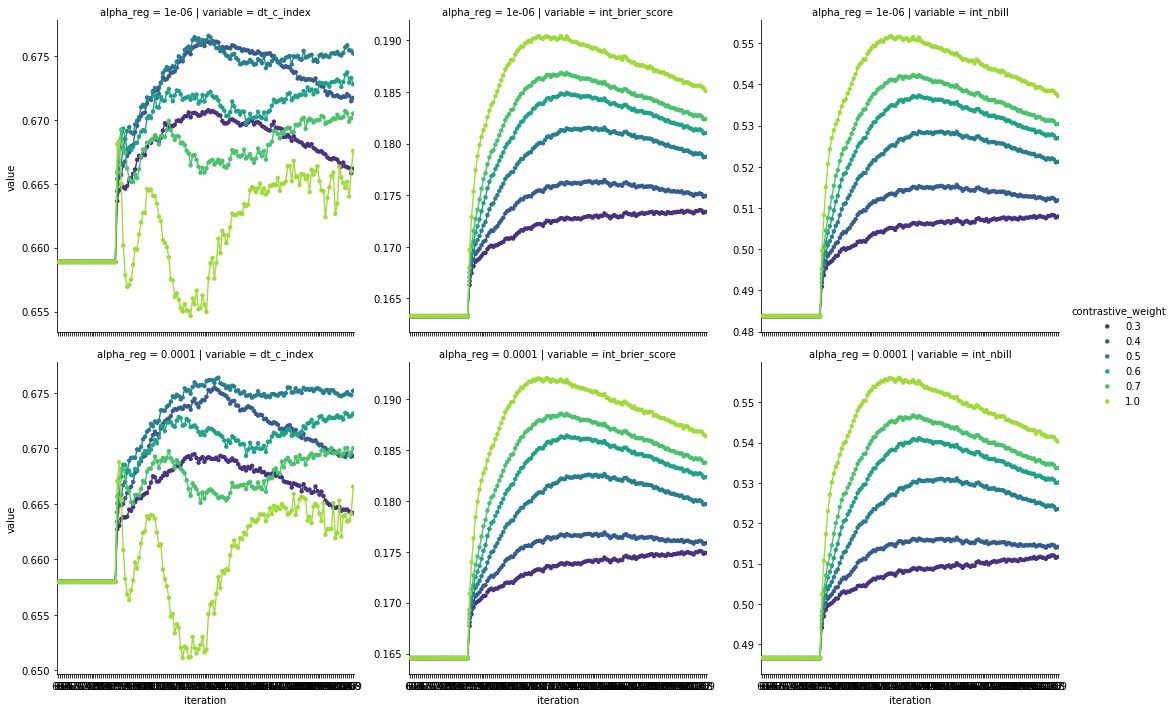

In [100]:
sns.catplot(data=melted_data[(melted_data['contrastive_weight'] > 0.1) & 
                             (melted_data['iteration'] >= 60) &
                             (melted_data['variable'].isin(['dt_c_index', 'int_brier_score', 'int_nbill']))], 
            x='iteration', y='value', hue='contrastive_weight', kind='point', row='alpha_reg', col='variable', sharey=False, markers='o', scale = 0.5,
            palette='viridis');

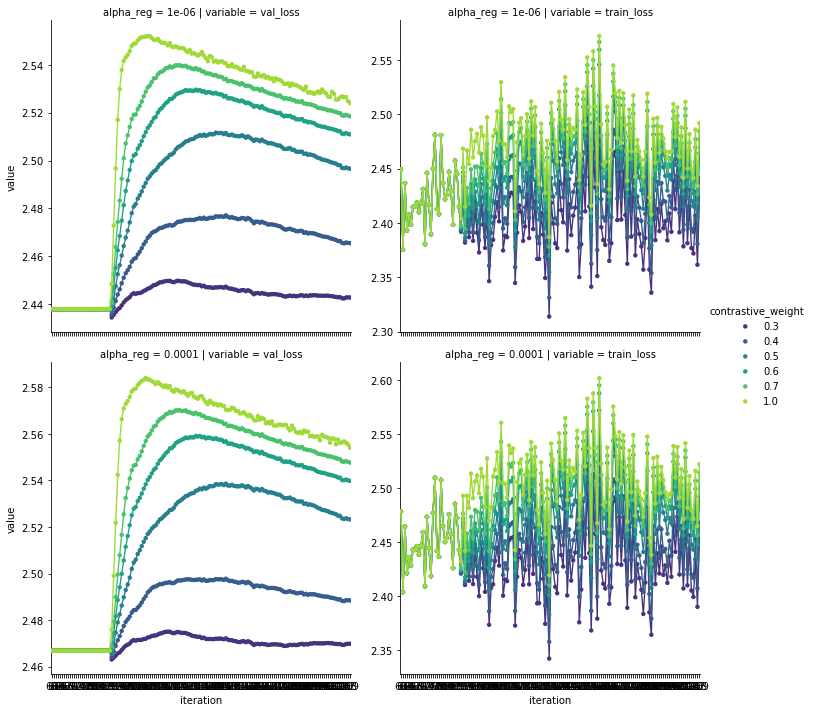

In [102]:
sns.catplot(data=melted_data[(melted_data['contrastive_weight'] > 0.1) & 
                             (melted_data['iteration'] >= 60) &
                             (melted_data['variable'].isin(['train_loss', 'val_loss']))], 
            x='iteration', y='value', hue='contrastive_weight', kind='point', row='alpha_reg', col='variable', sharey=False, markers='o', scale = 0.5,
            palette='viridis');

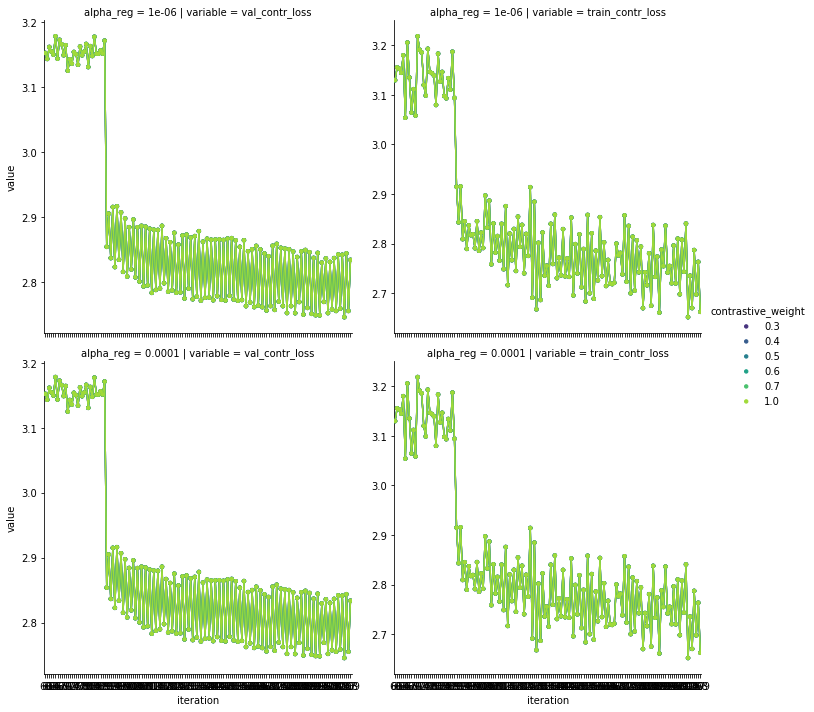

In [103]:
sns.catplot(data=melted_data[(melted_data['contrastive_weight'] > 0.1) & 
                             (melted_data['iteration'] >= 60) &
                             (melted_data['variable'].isin(['train_contr_loss', 'val_contr_loss']))], 
            x='iteration', y='value', hue='contrastive_weight', kind='point', row='alpha_reg', col='variable', sharey=False, markers='o', scale = 0.5,
            palette='viridis');

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
# ax[0].plot(train_loss, label='train loss likelihood')
# ax[0].plot(val_loss, label='val loss likelihood')
# ax[0].legend(loc=1)
# ax[0].axvline(params['n_epochs_binary'], c='black', linestyle='--')
# ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
# ax[1].plot(train_loss[20:], label='train loss likelihood')
# ax[1].plot(val_loss[20:], label='val loss likelihood')
# ax[1].legend(loc=2)    
# plt.show();
    
# plt.figure(figsize=(10, 6))
# plt.plot(train_contr_loss, label='train contrastive loss')
# plt.plot(val_contr_loss, label='val contrastive loss')
# plt.legend(loc=1)  
# plt.show();

# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
# ax[0].plot(df_all_q['dt_c_index'].values)
# ax[0].set_title('dt_c_index')
# ax[0].axvline(params['n_epochs_binary'], c='black', linestyle='--')
# ax[0].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
# ax[1].plot(df_all_q['int_brier_score'].values)
# ax[1].axvline(params['n_epochs_binary'], c='black', linestyle='--')
# ax[1].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
# ax[1].set_title('int_brier_score')
# ax[2].plot(df_all_q['int_nbill'].values)
# ax[2].set_title('int_nbill')
# ax[2].axvline(params['n_epochs_binary'], c='black', linestyle='--')
# ax[2].axvline(params['n_epochs_binary'] + params['n_epochs_contrastive_freezed'], c='black', linestyle='--')
# plt.show();


для 0,6 показать лоссы и метрики качества отдельная линия для каждого фолда + посчитать по ним доверительный интервал и показать средниеи и дов инт